<a href="https://colab.research.google.com/github/mynameislllyt/API_Experiment/blob/main/fenlei2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# ============================================================
# 1.1 导入必要的库
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

df = pd.read_csv('dynamic_api_call_sequence_per_malware_100_0_306.csv')
# 检查标签分布
print(df['malware'].value_counts())


malware
1    42797
0     1079
Name: count, dtype: int64


步骤1：数据基本信息

总样本数: 43876

标签分布:
malware
1    42797
0     1079
Name: count, dtype: int64

正常样本占比: 2.46%

步骤2：提取正常样本

API序列长度: 100

正常样本: 1079 个
恶意样本: 42797 个

步骤3：正常样本特征分析

正常样本统计:
  使用的不同API数量: 199
  平均序列长度: 100.0
  平均API多样性: 23.8

  最常用的前5个API (ID: 频次):
    API 117: 14371 次
    API 215: 8814 次
    API 260: 8495 次
    API 65: 7978 次
    API 240: 7651 次

步骤4：可视化分析


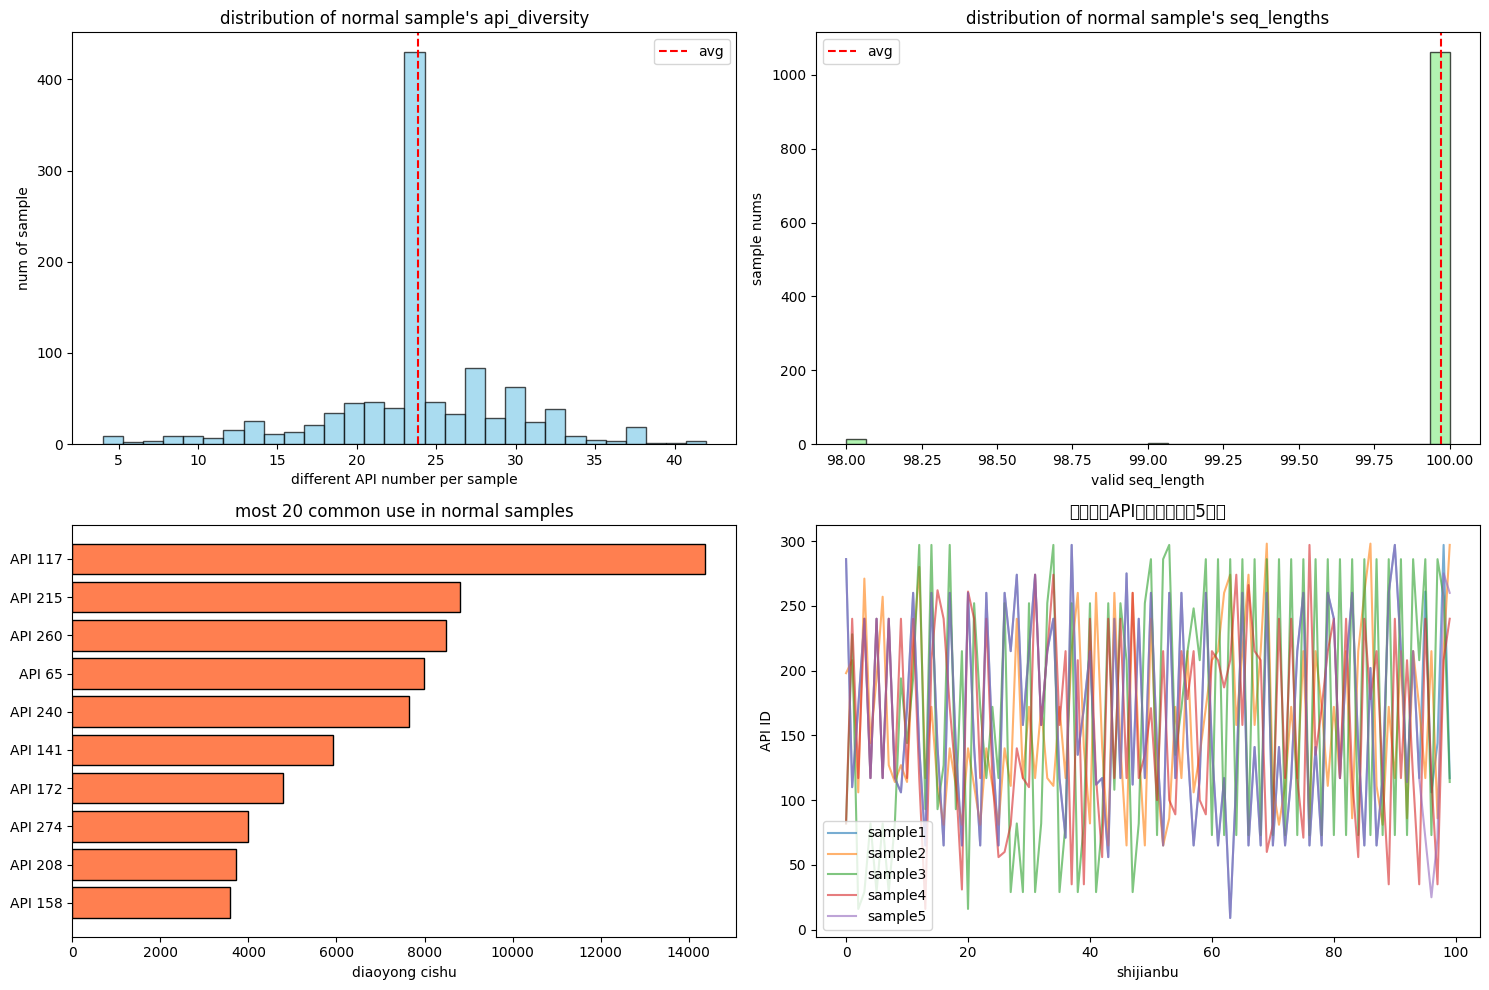


✓ 可视化完成

步骤5：数据集划分

数据集划分完成:
  训练集: 755 个正常样本
  验证集: 162 个正常样本
  测试集: 324 个样本
    - 正常: 162 个
    - 恶意: 162 个
    - 平衡比例: 1.00

✓ 第一步完成！

接下来我们将进行:
  第二步: 状态聚类（发现正常行为的不同阶段）
  第三步: 构建多超球体模型
  第四步: 训练模型
  第五步: 异常检测与评估


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ============================================================
# 步骤1：加载并检查数据
# ============================================================

# 假设你的数据已经加载到 df
# df = pd.read_csv('your_file.csv', sep='\t')

print("=" * 60)
print("步骤1：数据基本信息")
print("=" * 60)

# 基本统计
print(f"\n总样本数: {len(df)}")
print(f"\n标签分布:")
print(df['malware'].value_counts())
print(f"\n正常样本占比: {(df['malware']==0).sum()/len(df)*100:.2f}%")

# ============================================================
# 步骤2：提取正常样本
# ============================================================

print("\n" + "=" * 60)
print("步骤2：提取正常样本")
print("=" * 60)

# 获取序列列
sequence_cols = [col for col in df.columns if col.startswith('t_')]
print(f"\nAPI序列长度: {len(sequence_cols)}")

# 分离正常和恶意样本
normal_samples = df[df['malware'] == 0]
malware_samples = df[df['malware'] == 1]

X_normal = normal_samples[sequence_cols].values
X_malware = malware_samples[sequence_cols].values

print(f"\n正常样本: {len(X_normal)} 个")
print(f"恶意样本: {len(X_malware)} 个")

# ============================================================
# 步骤3：分析正常样本的API使用模式
# ============================================================

print("\n" + "=" * 60)
print("步骤3：正常样本特征分析")
print("=" * 60)

# 统计正常样本的API使用情况
def analyze_api_patterns(X, label="正常"):
    """分析API调用模式"""

    # 去除填充值（假设0是padding）
    X_clean = X[X > 0]

    stats = {
        'unique_apis': len(np.unique(X_clean)),
        'avg_length': np.mean(np.sum(X > 0, axis=1)),
        'api_diversity': [],  # 每个样本的API多样性
        'most_common': []
    }

    # 每个样本的API多样性
    for seq in X:
        seq_clean = seq[seq > 0]
        if len(seq_clean) > 0:
            stats['api_diversity'].append(len(np.unique(seq_clean)))

    # 最常用的API
    all_apis = X_clean.flatten()
    unique, counts = np.unique(all_apis, return_counts=True)
    top_idx = np.argsort(counts)[-10:][::-1]
    stats['most_common'] = list(zip(unique[top_idx], counts[top_idx]))

    return stats

normal_stats = analyze_api_patterns(X_normal, "正常")

print(f"\n正常样本统计:")
print(f"  使用的不同API数量: {normal_stats['unique_apis']}")
print(f"  平均序列长度: {normal_stats['avg_length']:.1f}")
print(f"  平均API多样性: {np.mean(normal_stats['api_diversity']):.1f}")

print(f"\n  最常用的前5个API (ID: 频次):")
for api_id, count in normal_stats['most_common'][:5]:
    print(f"    API {api_id}: {count} 次")

# ============================================================
# 步骤4：可视化正常样本的特点
# ============================================================

print("\n" + "=" * 60)
print("步骤4：可视化分析")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 子图1：API多样性分布
axes[0, 0].hist(normal_stats['api_diversity'], bins=30,
                color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('different API number per sample')
axes[0, 0].set_ylabel('num of sample')
axes[0, 0].set_title('distribution of normal sample\'s api_diversity')
axes[0, 0].axvline(np.mean(normal_stats['api_diversity']),
                   color='red', linestyle='--', label='avg')
axes[0, 0].legend()

# 子图2：序列长度分布
seq_lengths = np.sum(X_normal > 0, axis=1)
axes[0, 1].hist(seq_lengths, bins=30,
                color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('valid seq_length')
axes[0, 1].set_ylabel('sample nums')
axes[0, 1].set_title('distribution of normal sample\'s seq_lengths')
axes[0, 1].axvline(np.mean(seq_lengths),
                   color='red', linestyle='--', label='avg')
axes[0, 1].legend()

# 子图3：API使用频率（Top 20）
top_20_apis = normal_stats['most_common'][:20]
api_ids = [x[0] for x in top_20_apis]
api_counts = [x[1] for x in top_20_apis]

axes[1, 0].barh(range(len(api_ids)), api_counts, color='coral', edgecolor='black')
axes[1, 0].set_yticks(range(len(api_ids)))
axes[1, 0].set_yticklabels([f'API {id}' for id in api_ids])
axes[1, 0].set_xlabel('diaoyong cishu')
axes[1, 0].set_title('most 20 common use in normal samples')
axes[1, 0].invert_yaxis()

# 子图4：样本示例（前5个正常样本）
for i in range(min(5, len(X_normal))):
    seq = X_normal[i]
    seq_clean = seq[seq > 0]
    axes[1, 1].plot(seq_clean, alpha=0.6, label=f'sample{i+1}')

axes[1, 1].set_xlabel('shijianbu')
axes[1, 1].set_ylabel('API ID')
axes[1, 1].set_title('正常样本API序列示例（前5个）')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ 可视化完成")

# ============================================================
# 步骤5：数据集划分策略
# ============================================================

print("\n" + "=" * 60)
print("步骤5：数据集划分")
print("=" * 60)

"""
划分策略：

训练集（70%）：只用正常样本
  → 学习正常API调用模式
  → 建立正常行为的超球体

验证集（15%）：正常样本
  → 调整超球体半径
  → 选择最佳阈值

测试集（15%）：正常 + 恶意样本（平衡）
  → 评估检测性能
  → 测试对恶意软件的识别能力
"""

# 先分割正常样本
X_train_normal, X_temp_normal = train_test_split(
    X_normal, test_size=0.3, random_state=42
)

X_val_normal, X_test_normal = train_test_split(
    X_temp_normal, test_size=0.5, random_state=42
)

# 测试集需要平衡：添加等量恶意样本
n_test_normal = len(X_test_normal)
X_test_malware = X_malware[np.random.choice(
    len(X_malware), n_test_normal, replace=False
)]

# 合并测试集
X_test = np.vstack([X_test_normal, X_test_malware])
y_test = np.concatenate([
    np.zeros(n_test_normal),  # 正常=0
    np.ones(n_test_normal)    # 恶意=1
])

# 打乱测试集
shuffle_idx = np.random.permutation(len(X_test))
X_test = X_test[shuffle_idx]
y_test = y_test[shuffle_idx]

# 训练和验证标签（全是正常）
y_train = np.zeros(len(X_train_normal))
y_val = np.zeros(len(X_val_normal))

print(f"\n数据集划分完成:")
print(f"  训练集: {len(X_train_normal)} 个正常样本")
print(f"  验证集: {len(X_val_normal)} 个正常样本")
print(f"  测试集: {len(X_test)} 个样本")
print(f"    - 正常: {(y_test==0).sum()} 个")
print(f"    - 恶意: {(y_test==1).sum()} 个")
print(f"    - 平衡比例: {(y_test==0).sum()/(y_test==1).sum():.2f}")

print("\n" + "=" * 60)
print("✓ 第一步完成！")
print("=" * 60)
print("\n接下来我们将进行:")
print("  第二步: 状态聚类（发现正常行为的不同阶段）")
print("  第三步: 构建多超球体模型")
print("  第四步: 训练模型")
print("  第五步: 异常检测与评估")


✓ 中文字体配置完成
第二步：状态聚类 - 发现正常行为的不同阶段

提取统计特征...
  样本数: 755
  序列长度: 100
  API词汇表大小: 307
  处理进度: 755/755 ✓

特征提取完成！
  特征维度: (755, 8)

确定最佳状态数

评估不同状态数...
  k=2: 惯性=4484, 轮廓系数=0.465
  k=3: 惯性=3679, 轮廓系数=0.497
  k=4: 惯性=3048, 轮廓系数=0.297
  k=5: 惯性=2585, 轮廓系数=0.338
  k=6: 惯性=2265, 轮廓系数=0.354
  k=7: 惯性=1960, 轮廓系数=0.379
  k=8: 惯性=1794, 轮廓系数=0.385


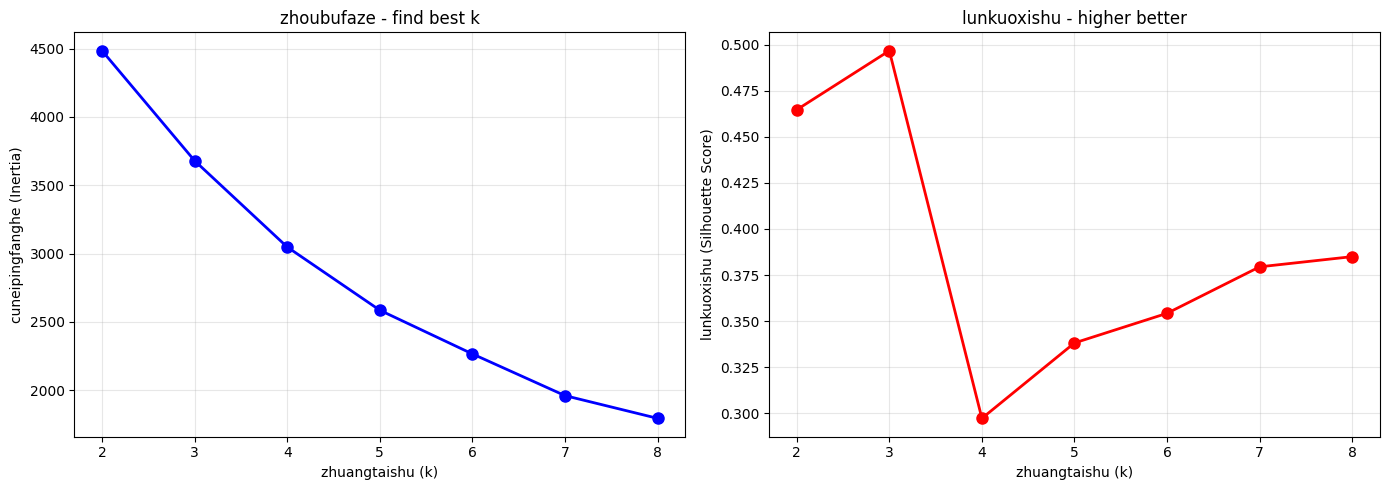


推荐状态数: k=3 (轮廓系数最高)

使用 k=3 进行状态聚类

聚类完成！

各状态的样本分布:
  状态 0: 650 个样本 (86.1%)
  状态 1: 12 个样本 (1.6%)
  状态 2: 93 个样本 (12.3%)

分析各状态特征

状态特征对比:
--------------------------------------------------------------------------------
特征             状态0       状态1       状态2       
--------------------------------------------------------------------------------
有效长度           100.00  98.25   100.00  
API多样性         25.09   34.42   13.91   
平均API_ID       162.79  156.43  173.93  
API_ID标准差      77.59   67.11   59.11   
平均切换幅度         99.69   83.58   80.72   
调用模式熵          2.69    3.03    1.79    
前后半差异          5.81    4.08    8.72    
API重复率         0.75    0.65    0.86    

可视化状态分布


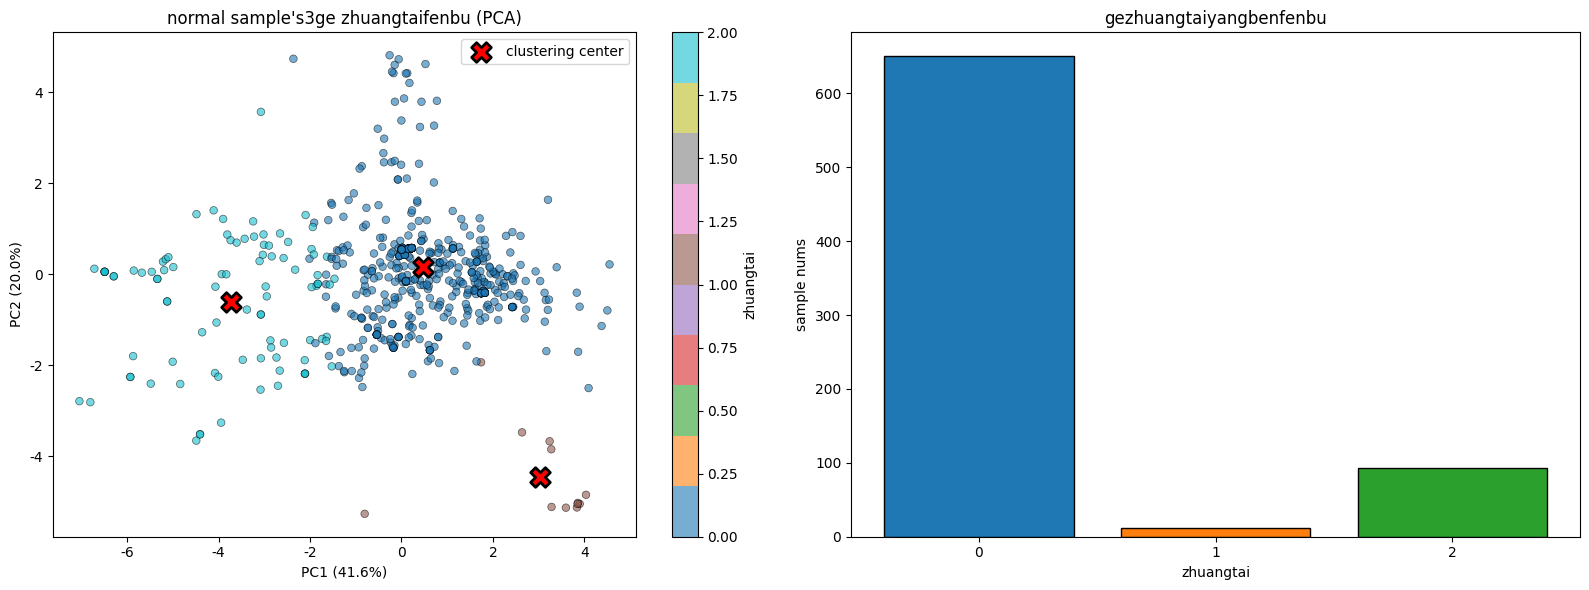


为验证集和测试集分配状态

提取统计特征...
  样本数: 162
  序列长度: 100
  API词汇表大小: 307
  处理进度: 162/162 ✓

特征提取完成！
  特征维度: (162, 8)

验证集状态分布:
  状态 0: 135 个样本
  状态 1: 4 个样本
  状态 2: 23 个样本

提取统计特征...
  样本数: 324
  序列长度: 100
  API词汇表大小: 307
  处理进度: 324/324 ✓

特征提取完成！
  特征维度: (324, 8)

测试集状态分布:
  状态 0: 274 个样本 (正常:135, 恶意:139)
  状态 1: 3 个样本 (正常:1, 恶意:2)
  状态 2: 47 个样本 (正常:26, 恶意:21)

✓ 第二步完成！

我们发现了正常行为的不同阶段：
  - 识别出 3 个不同的行为状态
  - 每个状态代表一种典型的API调用模式
  - 下一步将为每个状态建立一个超球体

接下来我们将进行:
  第三步: 构建多超球体LSTM模型


In [8]:
import matplotlib.pyplot as plt

# 快速修复中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 中文字体配置完成")

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import entropy
import matplotlib.pyplot as plt

# ============================================================
# 步骤1：从API序列提取统计特征
# ============================================================

print("=" * 60)
print("第二步：状态聚类 - 发现正常行为的不同阶段")
print("=" * 60)

def extract_statistical_features(X, vocab_size=None):
    """
    从API序列中提取统计特征

    参数:
        X: API序列矩阵 (n_samples, seq_length)
        vocab_size: API词汇表大小（自动计算如果为None）

    返回:
        features: 特征矩阵 (n_samples, n_features)
        feature_names: 特征名称列表
    """

    if vocab_size is None:
        vocab_size = int(X.max()) + 1

    print(f"\n提取统计特征...")
    print(f"  样本数: {len(X)}")
    print(f"  序列长度: {X.shape[1]}")
    print(f"  API词汇表大小: {vocab_size}")

    n_samples = len(X)
    features = []
    feature_names = []

    for i, seq in enumerate(X):
        # 去除padding（假设0是padding）
        seq_clean = seq[seq > 0]

        if len(seq_clean) == 0:
            # 如果序列为空，使用零特征
            feat = [0] * 8
        else:
            # 1. 序列统计特征
            feat = [
                len(seq_clean),                          # 有效长度
                len(np.unique(seq_clean)),               # API多样性
                np.mean(seq_clean),                      # 平均API ID
                np.std(seq_clean),                       # API ID标准差
                np.mean(np.abs(np.diff(seq_clean))),    # 平均API切换幅度
            ]

            # 2. API频率分布的熵（衡量调用模式的随机性）
            api_counts = np.bincount(seq_clean.astype(int), minlength=vocab_size)
            api_probs = api_counts[api_counts > 0] / len(seq_clean)
            feat.append(entropy(api_probs))              # 调用模式熵

            # 3. 序列局部变化特征
            # 前半部分和后半部分的API多样性差异
            mid = len(seq_clean) // 2
            first_half_diversity = len(np.unique(seq_clean[:mid]))
            second_half_diversity = len(np.unique(seq_clean[mid:]))
            feat.append(abs(first_half_diversity - second_half_diversity))

            # 4. API重复率
            repeat_rate = 1 - len(np.unique(seq_clean)) / len(seq_clean)
            feat.append(repeat_rate)

        features.append(feat)

        if i % 100 == 0:
            print(f"  处理进度: {i}/{n_samples}", end='\r')

    print(f"  处理进度: {n_samples}/{n_samples} ✓")

    features = np.array(features)

    feature_names = [
        '有效长度', 'API多样性', '平均API_ID', 'API_ID标准差',
        '平均切换幅度', '调用模式熵', '前后半差异', 'API重复率'
    ]

    print(f"\n特征提取完成！")
    print(f"  特征维度: {features.shape}")

    return features, feature_names

# 提取训练集特征
vocab_size = int(X_train_normal.max()) + 1
features_train, feature_names = extract_statistical_features(
    X_train_normal, vocab_size
)

# ============================================================
# 步骤2：确定最佳状态数（肘部法则）
# ============================================================

print("\n" + "=" * 60)
print("确定最佳状态数")
print("=" * 60)

def find_optimal_states(features, max_states=8):
    """
    使用肘部法则和轮廓系数找到最佳状态数
    """

    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 尝试不同的状态数
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_states + 1)

    print("\n评估不同状态数...")

    from sklearn.metrics import silhouette_score

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(features_scaled)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features_scaled, labels))

        print(f"  k={k}: 惯性={kmeans.inertia_:.0f}, 轮廓系数={silhouette_scores[-1]:.3f}")

    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 肘部图
    axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('zhuangtaishu (k)')
    axes[0].set_ylabel('cuneipingfanghe (Inertia)')
    axes[0].set_title('zhoubufaze - find best k')
    axes[0].grid(True, alpha=0.3)

    # 轮廓系数
    axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('zhuangtaishu (k)')
    axes[1].set_ylabel('lunkuoxishu (Silhouette Score)')
    axes[1].set_title('lunkuoxishu - higher better')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 推荐k值（轮廓系数最高）
    best_k = K_range[np.argmax(silhouette_scores)]
    print(f"\n推荐状态数: k={best_k} (轮廓系数最高)")

    return best_k, scaler

optimal_k, scaler = find_optimal_states(features_train, max_states=8)

# ============================================================
# 步骤3：执行K-means聚类
# ============================================================

print("\n" + "=" * 60)
print(f"使用 k={optimal_k} 进行状态聚类")
print("=" * 60)

# 标准化特征
features_train_scaled = scaler.transform(features_train)

# K-means聚类
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
state_labels_train = kmeans.fit_predict(features_train_scaled)

print(f"\n聚类完成！")
print(f"\n各状态的样本分布:")
for i in range(optimal_k):
    count = np.sum(state_labels_train == i)
    print(f"  状态 {i}: {count} 个样本 ({count/len(state_labels_train)*100:.1f}%)")

# ============================================================
# 步骤4：分析每个状态的特点
# ============================================================

print("\n" + "=" * 60)
print("分析各状态特征")
print("=" * 60)

# 计算每个状态的特征均值
state_profiles = []
for i in range(optimal_k):
    mask = (state_labels_train == i)
    state_feat = features_train[mask]
    state_mean = np.mean(state_feat, axis=0)
    state_profiles.append(state_mean)

state_profiles = np.array(state_profiles)

# 打印各状态的特征
print("\n状态特征对比:")
print("-" * 80)
print(f"{'特征':<15}", end='')
for i in range(optimal_k):
    print(f"状态{i:<8}", end='')
print()
print("-" * 80)

for j, fname in enumerate(feature_names):
    print(f"{fname:<15}", end='')
    for i in range(optimal_k):
        print(f"{state_profiles[i, j]:<8.2f}", end='')
    print()

# ============================================================
# 步骤5：可视化状态分布
# ============================================================

print("\n" + "=" * 60)
print("可视化状态分布")
print("=" * 60)

# PCA降维到2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图：PCA可视化
scatter = axes[0].scatter(features_2d[:, 0], features_2d[:, 1],
                         c=state_labels_train, cmap='tab10',
                         alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title(f'normal sample\'s{optimal_k}ge zhuangtaifenbu (PCA)')
plt.colorbar(scatter, ax=axes[0], label='zhuangtai')

# 绘制聚类中心
centers_2d = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centers_2d[:, 0], centers_2d[:, 1],
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label='clustering center')
axes[0].legend()

# 右图：每个状态的样本数量
state_counts = [np.sum(state_labels_train == i) for i in range(optimal_k)]
colors = plt.cm.tab10(np.arange(optimal_k))
axes[1].bar(range(optimal_k), state_counts, color=colors, edgecolor='black')
axes[1].set_xlabel('zhuangtai')
axes[1].set_ylabel('sample nums')
axes[1].set_title('gezhuangtaiyangbenfenbu')
axes[1].set_xticks(range(optimal_k))

plt.tight_layout()
plt.show()

# ============================================================
# 步骤6：为验证集和测试集分配状态
# ============================================================

print("\n" + "=" * 60)
print("为验证集和测试集分配状态")
print("=" * 60)

# 提取验证集特征
features_val, _ = extract_statistical_features(X_val_normal, vocab_size)
features_val_scaled = scaler.transform(features_val)
state_labels_val = kmeans.predict(features_val_scaled)

print(f"\n验证集状态分布:")
for i in range(optimal_k):
    count = np.sum(state_labels_val == i)
    print(f"  状态 {i}: {count} 个样本")

# 提取测试集特征
features_test, _ = extract_statistical_features(X_test, vocab_size)
features_test_scaled = scaler.transform(features_test)
state_labels_test = kmeans.predict(features_test_scaled)

print(f"\n测试集状态分布:")
for i in range(optimal_k):
    count = np.sum(state_labels_test == i)
    count_normal = np.sum((state_labels_test == i) & (y_test == 0))
    count_malware = np.sum((state_labels_test == i) & (y_test == 1))
    print(f"  状态 {i}: {count} 个样本 (正常:{count_normal}, 恶意:{count_malware})")

print("\n" + "=" * 60)
print("✓ 第二步完成！")
print("=" * 60)
print("\n我们发现了正常行为的不同阶段：")
print(f"  - 识别出 {optimal_k} 个不同的行为状态")
print(f"  - 每个状态代表一种典型的API调用模式")
print(f"  - 下一步将为每个状态建立一个超球体")

print("\n接下来我们将进行:")
print("  第三步: 构建多超球体LSTM模型")


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ============================================================
# 第三步：构建多超球体LSTM模型
# ============================================================

print("=" * 60)
print("第三步：构建多超球体LSTM模型")
print("=" * 60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n使用设备: {device}")

# ============================================================
# 3.1: 数据集类
# ============================================================

class APISequenceDataset(Dataset):
    """
    API序列数据集（PyTorch格式）
    """
    def __init__(self, sequences, state_labels):
        """
        Args:
            sequences: numpy array (n_samples, seq_length)
            state_labels: numpy array (n_samples,)
        """
        self.sequences = torch.LongTensor(sequences)
        self.state_labels = torch.LongTensor(state_labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.state_labels[idx]

# 创建数据集
train_dataset = APISequenceDataset(X_train_normal, state_labels_train)
val_dataset = APISequenceDataset(X_val_normal, state_labels_val)

print(f"\n数据集创建完成:")
print(f"  训练样本: {len(train_dataset)}")
print(f"  验证样本: {len(val_dataset)}")

# ============================================================
# 3.2: 多超球体LSTM模型
# ============================================================

class MultiHypersphereLSTM(nn.Module):
    """
    多超球体LSTM异常检测模型

    架构:
        输入 → 嵌入层 → 双向LSTM → 特征提取器 → 状态分类器
                                           ↓
                            计算到超球体中心的距离
    """

    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128,
                 num_states=4, dropout=0.3):
        super(MultiHypersphereLSTM, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_states = num_states

        # 1. 嵌入层
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=0
        )

        # 2. 双向LSTM层
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # 3. 特征提取器（LSTM之后）
        self.feature_extractor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 4. 状态分类器
        self.state_classifier = nn.Linear(hidden_dim, num_states)

        # 5. 超球体中心（可学习参数）
        # 每个状态在特征空间中有自己的中心
        self.centers = nn.Parameter(
            torch.randn(num_states, hidden_dim) * 0.1
        )

        # 6. 每个超球体的半径（可学习，使用log确保正值）
        self.log_radius = nn.Parameter(
            torch.zeros(num_states)
        )

        print(f"\n模型架构:")
        print(f"  词汇表大小: {vocab_size}")
        print(f"  嵌入维度: {embedding_dim}")
        print(f"  隐藏维度: {hidden_dim}")
        print(f"  状态数量: {num_states}")
        print(f"  总参数量: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        """
        前向传播

        Args:
            x: 输入序列 (batch_size, seq_length)

        Returns:
            features: 提取的特征 (batch_size, hidden_dim)
            state_logits: 状态分类logits (batch_size, num_states)
        """
        # 1. 嵌入
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)

        # 2. LSTM
        lstm_out, _ = self.lstm(embedded)  # (batch, seq_len, hidden*2)

        # 3. 取最后一个隐藏状态
        last_hidden = lstm_out[:, -1, :]  # (batch, hidden*2)

        # 4. 提取特征
        features = self.feature_extractor(last_hidden)  # (batch, hidden)

        # 5. 状态分类
        state_logits = self.state_classifier(features)  # (batch, num_states)

        return features, state_logits

    def compute_distances(self, features, state_labels):
        """
        计算到超球体中心的距离

        Args:
            features: (batch_size, hidden_dim)
            state_labels: (batch_size,)

        Returns:
            distances: 到指定中心的距离 (batch_size,)
            all_distances: 到所有中心的距离 (batch_size, num_states)
        """
        # 到所有中心的距离
        # features: (batch, hidden)
        # centers: (num_states, hidden)

        features_expanded = features.unsqueeze(1)  # (batch, 1, hidden)
        centers_expanded = self.centers.unsqueeze(0)  # (1, num_states, hidden)

        # 欧氏距离
        all_distances = torch.norm(
            features_expanded - centers_expanded,
            p=2,
            dim=2
        )  # (batch, num_states)

        # 到指定中心的距离
        batch_size = features.size(0)
        distances = all_distances[
            torch.arange(batch_size, device=features.device),
            state_labels
        ]

        return distances, all_distances

    def get_radius(self, state_labels=None):
        """
        获取半径（使用exp确保正值）

        Args:
            state_labels: 如果提供，返回特定状态的半径

        Returns:
            radius: 正的半径值
        """
        radius = torch.exp(self.log_radius)

        if state_labels is not None:
            return radius[state_labels]

        return radius

    def anomaly_score(self, features, state_labels):
        """
        计算异常分数

        分数 = max(0, 距离 - 半径)
        如果距离 > 半径，则为异常

        Args:
            features: (batch_size, hidden_dim)
            state_labels: (batch_size,)

        Returns:
            scores: 异常分数 (batch_size,)
            distances: 到中心的距离 (batch_size,)
        """
        distances, _ = self.compute_distances(features, state_labels)
        radius = self.get_radius(state_labels)

        # 异常分数 = 超出半径的距离
        scores = torch.relu(distances - radius)

        return scores, distances

# ============================================================
# 3.3: 初始化模型
# ============================================================

print("\n" + "=" * 60)
print("初始化模型")
print("=" * 60)

# 模型超参数
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
DROPOUT = 0.3
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# 创建模型
model = MultiHypersphereLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_states=optimal_k,
    dropout=DROPOUT
)

model = model.to(device)

print(f"\n✓ 模型初始化成功")

# ============================================================
# 3.4: 损失函数
# ============================================================

class HypersphereLoss(nn.Module):
    """
    多超球体学习的自定义损失函数

    组成部分:
    1. 状态分类损失（交叉熵）
    2. 紧凑性损失（最小化到中心的距离）
    3. 半径正则化（防止半径过大）
    """

    def __init__(self, lambda_compact=1.0, lambda_radius=0.01):
        super(HypersphereLoss, self).__init__()

        self.lambda_compact = lambda_compact
        self.lambda_radius = lambda_radius

        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, state_logits, state_labels, distances, radius):
        """
        计算总损失

        Args:
            state_logits: (batch, num_states)
            state_labels: (batch,)
            distances: 到中心的距离 (batch,)
            radius: 半径值 (batch,)

        Returns:
            total_loss: 组合损失
            loss_dict: 各损失分量
        """
        # 1. 状态分类损失
        classification_loss = self.ce_loss(state_logits, state_labels)

        # 2. 紧凑性损失（将样本拉向其中心）
        compactness_loss = torch.mean(distances)

        # 3. 半径正则化（防止半径增长过大）
        radius_reg = torch.mean(radius)

        # 总损失
        total_loss = (
            classification_loss +
            self.lambda_compact * compactness_loss +
            self.lambda_radius * radius_reg
        )

        loss_dict = {
            'total': total_loss.item(),
            'classification': classification_loss.item(),
            'compactness': compactness_loss.item(),
            'radius_reg': radius_reg.item()
        }

        return total_loss, loss_dict

# 初始化损失函数
criterion = HypersphereLoss(
    lambda_compact=1.0,
    lambda_radius=0.01
)

print(f"\n损失函数初始化:")
print(f"  Lambda compact: {criterion.lambda_compact}")
print(f"  Lambda radius: {criterion.lambda_radius}")

# ============================================================
# 3.5: 优化器
# ============================================================

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 学习率调度器（修复：移除verbose参数）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print(f"\n优化器: Adam")
print(f"  学习率: {LEARNING_RATE}")
print(f"  调度器: ReduceLROnPlateau (patience=5, factor=0.5)")

# ============================================================
# 3.6: DataLoader
# ============================================================

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nDataLoader创建完成:")
print(f"  批次大小: {BATCH_SIZE}")
print(f"  训练批次数: {len(train_loader)}")
print(f"  验证批次数: {len(val_loader)}")

# ============================================================
# 3.7: 模型总结
# ============================================================

print("\n" + "=" * 60)
print("模型总结")
print("=" * 60)

def count_parameters(model):
    """统计可训练参数"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n可训练参数: {count_parameters(model):,}")

print(f"\n超球体中心形状: {model.centers.shape}")
print(f"初始半径值: {model.get_radius().detach().cpu().numpy()}")

print("\n" + "=" * 60)
print("✓ 第三步完成！")
print("=" * 60)

print("\n模型已准备好训练！")
print("\n下一步:")
print("  第四步：在正常样本上训练模型")


第三步：构建多超球体LSTM模型

使用设备: cuda

数据集创建完成:
  训练样本: 755
  验证样本: 162

初始化模型

模型架构:
  词汇表大小: 307
  嵌入维度: 64
  隐藏维度: 128
  状态数量: 3
  总参数量: 663,750

✓ 模型初始化成功

损失函数初始化:
  Lambda compact: 1.0
  Lambda radius: 0.01

优化器: Adam
  学习率: 0.001
  调度器: ReduceLROnPlateau (patience=5, factor=0.5)

DataLoader创建完成:
  批次大小: 64
  训练批次数: 12
  验证批次数: 3

模型总结

可训练参数: 663,750

超球体中心形状: torch.Size([3, 128])
初始半径值: [1. 1. 1.]

✓ 第三步完成！

模型已准备好训练！

下一步:
  第四步：在正常样本上训练模型


第四步：训练多超球体LSTM模型

开始训练

训练配置:
  训练轮数: 50
  Early stopping patience: 10
  设备: cuda
  批次大小: 64

开始训练...

--------------------------------------------------------------------------------

Epoch [  1/50] - 1.7s
  Train Loss: 2.1163 | Acc: 61.19%
  Val   Loss: 1.9230 | Acc: 83.33%
  Avg Distance: 0.8788 | Avg Radius: 0.9888
  Loss Components:
    - Classification: 1.0346
    - Compactness:    0.8785
    - Radius Reg:     0.9880
--------------------------------------------------------------------------------

Epoch [  5/50] - 0.2s
  Train Loss: 1.5031 | Acc: 86.09%
  Val   Loss: 1.3468 | Acc: 83.33%
  Avg Distance: 0.5265 | Avg Radius: 0.9457
  Loss Components:
    - Classification: 0.8111
    - Compactness:    0.5263
    - Radius Reg:     0.9412
--------------------------------------------------------------------------------
  ✓ 新的最佳模型 (Val Loss: 1.3468)

Epoch [ 10/50] - 0.2s
  Train Loss: 1.0792 | Acc: 86.09%
  Val   Loss: 0.9165 | Acc: 83.33%
  Avg Distance: 0.2978 | Avg Radius: 0.8965
 


Epoch [ 50/50] - 0.2s
  Train Loss: 0.5160 | Acc: 86.09%
  Val   Loss: 0.4484 | Acc: 83.33%
  Avg Distance: 0.0385 | Avg Radius: 0.6177
  Loss Components:
    - Classification: 0.4038
    - Compactness:    0.0387
    - Radius Reg:     0.5909
--------------------------------------------------------------------------------
  ✓ 新的最佳模型 (Val Loss: 0.4484)

训练完成！

总训练时间: 9.8s (0.2 min)
最佳验证损失: 0.4484
最终训练准确率: 86.09%
最终验证准确率: 83.33%

✓ 已加载最佳模型

可视化训练过程


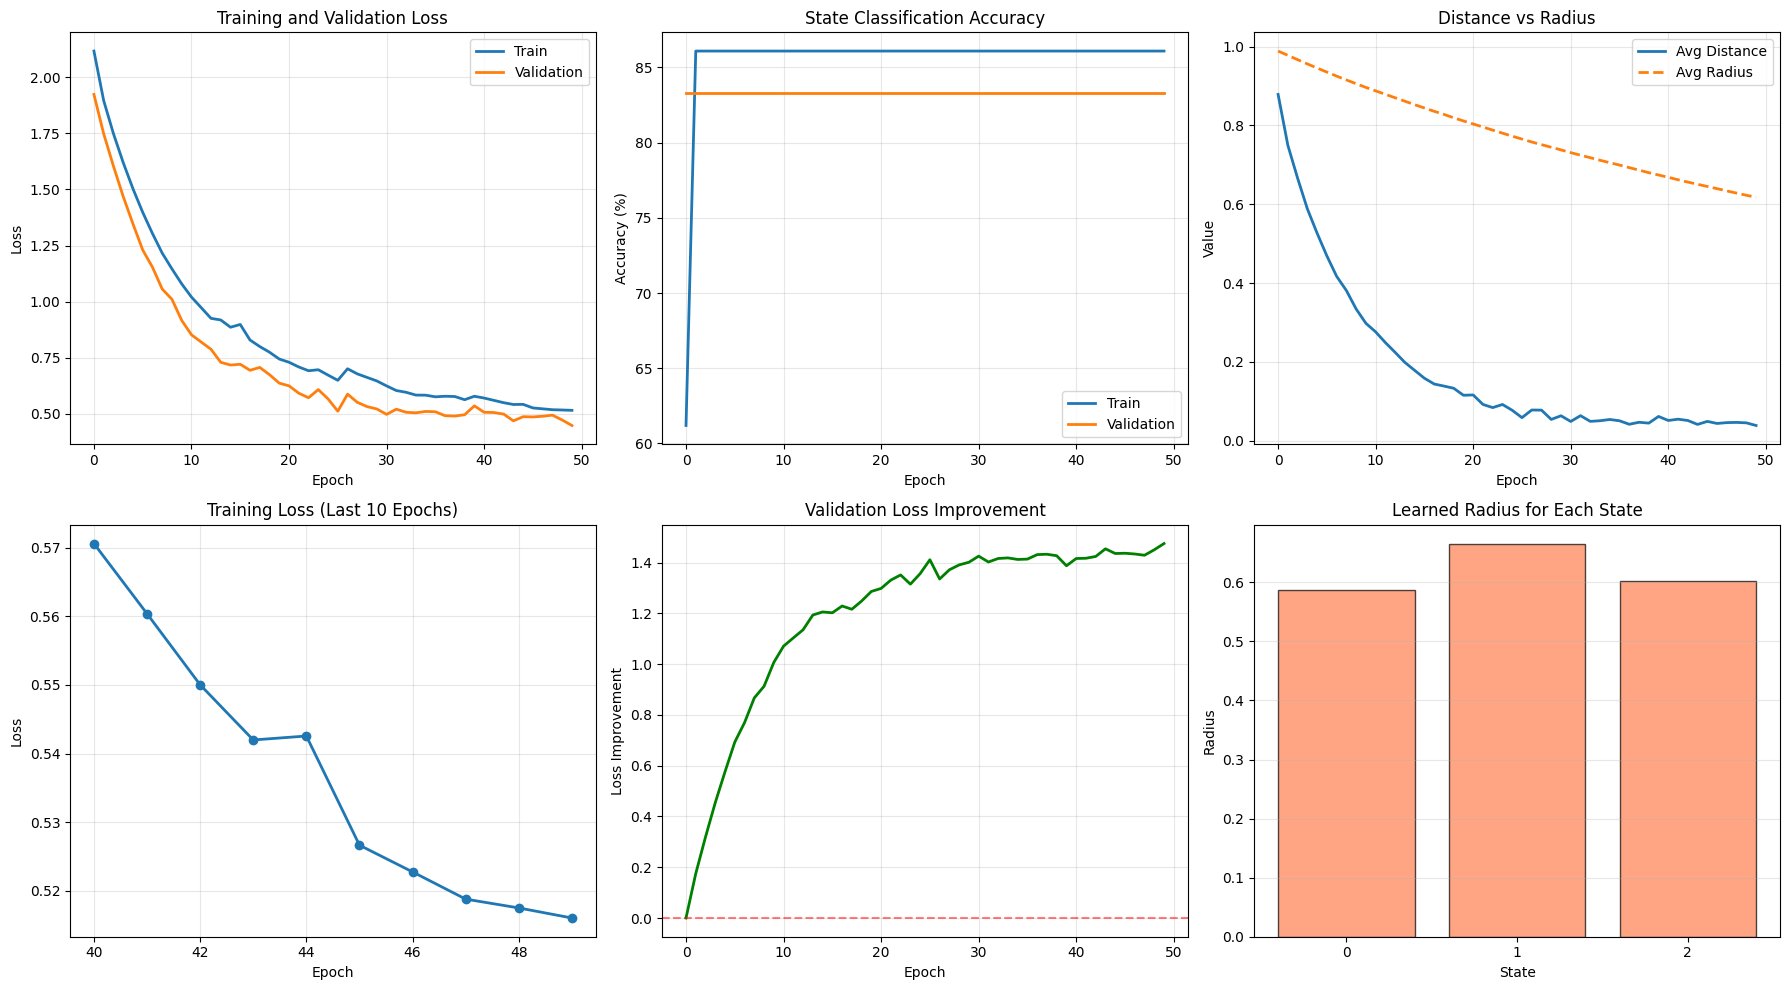


训练结果分析

最终模型统计:
  各状态的半径:
    状态 0: 0.5868
    状态 1: 0.6642
    状态 2: 0.6021

  半径统计:
    最小半径: 0.5868
    最大半径: 0.6642
    平均半径: 0.6177
    半径标准差: 0.0334

验证集距离统计（按状态）:
  状态 0:
    样本数: 135
    平均距离: 0.0239
    距离标准差: 0.0657
    距离 < 半径: 135 / 135 (100.0%)
  状态 1:
    样本数: 4
    平均距离: 0.0018
    距离标准差: 0.0000
    距离 < 半径: 4 / 4 (100.0%)
  状态 2:
    样本数: 23
    平均距离: 0.1303
    距离标准差: 0.1713
    距离 < 半径: 23 / 23 (100.0%)


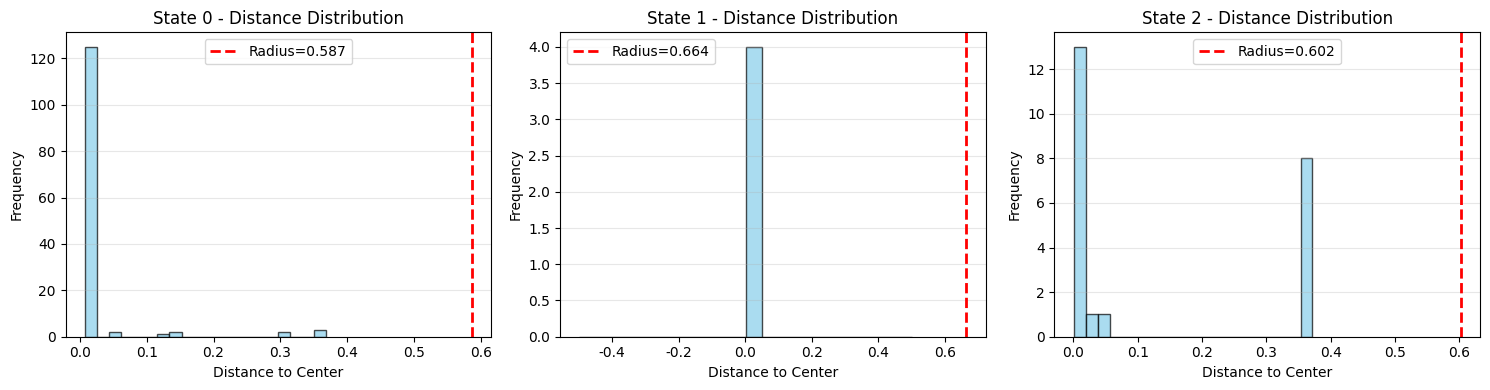


✓ 第四步完成！

模型训练完成！关键观察:
  1. 损失函数是否收敛
  2. 验证准确率是否稳定
  3. 距离是否小于半径（正常样本应该在超球体内）
  4. 各状态的半径是否合理

下一步:
  第五步：在测试集上评估异常检测性能


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# ============================================================
# 第四步：训练模型
# ============================================================

print("=" * 60)
print("第四步：训练多超球体LSTM模型")
print("=" * 60)

# ============================================================
# 4.1: 训练函数
# ============================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    训练一个epoch

    Returns:
        avg_loss: 平均总损失
        loss_components: 各损失分量的平均值
        accuracy: 状态分类准确率
    """
    model.train()

    total_loss = 0
    loss_components = {
        'classification': 0,
        'compactness': 0,
        'radius_reg': 0
    }

    correct = 0
    total = 0

    for sequences, state_labels in train_loader:
        sequences = sequences.to(device)
        state_labels = state_labels.to(device)

        # 前向传播
        features, state_logits = model(sequences)

        # 计算距离和半径
        distances, _ = model.compute_distances(features, state_labels)
        radius = model.get_radius(state_labels)

        # 计算损失
        loss, loss_dict = criterion(
            state_logits, state_labels, distances, radius
        )

        # 反向传播
        optimizer.zero_grad()
        loss.backward()

        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # 统计
        total_loss += loss.item()
        for key in loss_components:
            loss_components[key] += loss_dict[key]

        # 计算准确率
        _, predicted = torch.max(state_logits, 1)
        total += state_labels.size(0)
        correct += (predicted == state_labels).sum().item()

    # 计算平均值
    n_batches = len(train_loader)
    avg_loss = total_loss / n_batches

    for key in loss_components:
        loss_components[key] /= n_batches

    accuracy = 100 * correct / total

    return avg_loss, loss_components, accuracy

# ============================================================
# 4.2: 验证函数
# ============================================================

def validate(model, val_loader, criterion, device):
    """
    验证模型

    Returns:
        avg_loss: 平均总损失
        loss_components: 各损失分量的平均值
        accuracy: 状态分类准确率
        avg_distance: 平均距离
        avg_radius: 平均半径
    """
    model.eval()

    total_loss = 0
    loss_components = {
        'classification': 0,
        'compactness': 0,
        'radius_reg': 0
    }

    correct = 0
    total = 0
    all_distances = []

    with torch.no_grad():
        for sequences, state_labels in val_loader:
            sequences = sequences.to(device)
            state_labels = state_labels.to(device)

            # 前向传播
            features, state_logits = model(sequences)

            # 计算距离和半径
            distances, _ = model.compute_distances(features, state_labels)
            radius = model.get_radius(state_labels)

            # 计算损失
            loss, loss_dict = criterion(
                state_logits, state_labels, distances, radius
            )

            # 统计
            total_loss += loss.item()
            for key in loss_components:
                loss_components[key] += loss_dict[key]

            # 计算准确率
            _, predicted = torch.max(state_logits, 1)
            total += state_labels.size(0)
            correct += (predicted == state_labels).sum().item()

            # 记录距离
            all_distances.extend(distances.cpu().numpy())

    # 计算平均值
    n_batches = len(val_loader)
    avg_loss = total_loss / n_batches

    for key in loss_components:
        loss_components[key] /= n_batches

    accuracy = 100 * correct / total
    avg_distance = np.mean(all_distances)
    avg_radius = model.get_radius().mean().item()

    return avg_loss, loss_components, accuracy, avg_distance, avg_radius

# ============================================================
# 4.3: 训练循环
# ============================================================

print("\n" + "=" * 60)
print("开始训练")
print("=" * 60)

# 训练参数
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

# 记录训练历史
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'avg_distance': [],
    'avg_radius': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n训练配置:")
print(f"  训练轮数: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"  设备: {device}")
print(f"  批次大小: {BATCH_SIZE}")

print("\n开始训练...\n")
print("-" * 80)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # 训练
    train_loss, train_loss_comp, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # 验证
    val_loss, val_loss_comp, val_acc, avg_dist, avg_rad = validate(
        model, val_loader, criterion, device
    )

    # 学习率调整
    scheduler.step(val_loss)

    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['avg_distance'].append(avg_dist)
    history['avg_radius'].append(avg_rad)

    # 打印进度
    epoch_time = time.time() - epoch_start

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"\nEpoch [{epoch+1:3d}/{NUM_EPOCHS}] - {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
        print(f"  Avg Distance: {avg_dist:.4f} | Avg Radius: {avg_rad:.4f}")
        print(f"  Loss Components:")
        print(f"    - Classification: {val_loss_comp['classification']:.4f}")
        print(f"    - Compactness:    {val_loss_comp['compactness']:.4f}")
        print(f"    - Radius Reg:     {val_loss_comp['radius_reg']:.4f}")
        print("-" * 80)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        if (epoch + 1) % 5 == 0:
            print(f"  ✓ 新的最佳模型 (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss:.4f}")
            break

total_time = time.time() - start_time

print("\n" + "=" * 60)
print("训练完成！")
print("=" * 60)
print(f"\n总训练时间: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"最佳验证损失: {best_val_loss:.4f}")
print(f"最终训练准确率: {history['train_acc'][-1]:.2f}%")
print(f"最终验证准确率: {history['val_acc'][-1]:.2f}%")

# 加载最佳模型
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ 已加载最佳模型")

# ============================================================
# 4.4: 可视化训练过程
# ============================================================

print("\n" + "=" * 60)
print("可视化训练过程")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 损失曲线
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 准确率曲线
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('State Classification Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 平均距离 vs 半径
axes[0, 2].plot(history['avg_distance'], label='Avg Distance', linewidth=2)
axes[0, 2].plot(history['avg_radius'], label='Avg Radius', linewidth=2, linestyle='--')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Value')
axes[0, 2].set_title('Distance vs Radius')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. 损失分量（最后10个epoch）
if len(history['train_loss']) >= 10:
    recent_epochs = range(len(history['train_loss']) - 10, len(history['train_loss']))
    axes[1, 0].plot(recent_epochs, history['train_loss'][-10:], 'o-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Training Loss (Last 10 Epochs)')
    axes[1, 0].grid(True, alpha=0.3)

# 5. 验证损失改善
val_loss_improvement = [history['val_loss'][0] - loss for loss in history['val_loss']]
axes[1, 1].plot(val_loss_improvement, linewidth=2, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss Improvement')
axes[1, 1].set_title('Validation Loss Improvement')
axes[1, 1].grid(True, alpha=0.3)

# 6. 学习到的半径
final_radius = model.get_radius().detach().cpu().numpy()
axes[1, 2].bar(range(len(final_radius)), final_radius,
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('State')
axes[1, 2].set_ylabel('Radius')
axes[1, 2].set_title('Learned Radius for Each State')
axes[1, 2].set_xticks(range(len(final_radius)))
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================
# 4.5: 分析训练结果
# ============================================================

print("\n" + "=" * 60)
print("训练结果分析")
print("=" * 60)

print(f"\n最终模型统计:")
print(f"  各状态的半径:")
for i, r in enumerate(final_radius):
    print(f"    状态 {i}: {r:.4f}")

print(f"\n  半径统计:")
print(f"    最小半径: {final_radius.min():.4f}")
print(f"    最大半径: {final_radius.max():.4f}")
print(f"    平均半径: {final_radius.mean():.4f}")
print(f"    半径标准差: {final_radius.std():.4f}")

# 分析验证集上的距离分布
model.eval()
val_distances_by_state = [[] for _ in range(optimal_k)]

with torch.no_grad():
    for sequences, state_labels in val_loader:
        sequences = sequences.to(device)
        state_labels = state_labels.to(device)

        features, _ = model(sequences)
        distances, _ = model.compute_distances(features, state_labels)

        for i in range(len(state_labels)):
            state = state_labels[i].item()
            dist = distances[i].item()
            val_distances_by_state[state].append(dist)

print(f"\n验证集距离统计（按状态）:")
for i in range(optimal_k):
    if len(val_distances_by_state[i]) > 0:
        dists = np.array(val_distances_by_state[i])
        print(f"  状态 {i}:")
        print(f"    样本数: {len(dists)}")
        print(f"    平均距离: {dists.mean():.4f}")
        print(f"    距离标准差: {dists.std():.4f}")
        print(f"    距离 < 半径: {(dists < final_radius[i]).sum()} / {len(dists)} "
              f"({(dists < final_radius[i]).mean()*100:.1f}%)")

# 可视化距离分布
fig, axes = plt.subplots(1, optimal_k, figsize=(5*optimal_k, 4))
if optimal_k == 1:
    axes = [axes]

for i in range(optimal_k):
    if len(val_distances_by_state[i]) > 0:
        axes[i].hist(val_distances_by_state[i], bins=20,
                    color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].axvline(final_radius[i], color='red',
                       linestyle='--', linewidth=2, label=f'Radius={final_radius[i]:.3f}')
        axes[i].set_xlabel('Distance to Center')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'State {i} - Distance Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ 第四步完成！")
print("=" * 60)

print("\n模型训练完成！关键观察:")
print("  1. 损失函数是否收敛")
print("  2. 验证准确率是否稳定")
print("  3. 距离是否小于半径（正常样本应该在超球体内）")
print("  4. 各状态的半径是否合理")

print("\n下一步:")
print("  第五步：在测试集上评估异常检测性能")


第五步：测试集异常检测评估

步骤1：在测试集上进行推理

测试集大小: 324
  正常样本: 162
  恶意样本: 162

开始推理...
  进度: 324/324 ✓

推理完成！

步骤2：分析异常分数分布

正常样本异常分数:
  均值: 0.0000
  标准差: 0.0000
  中位数: 0.0000
  最大值: 0.0000

恶意样本异常分数:
  均值: 0.0000
  标准差: 0.0000
  中位数: 0.0000
  最小值: 0.0000

分数差异: 0.0000


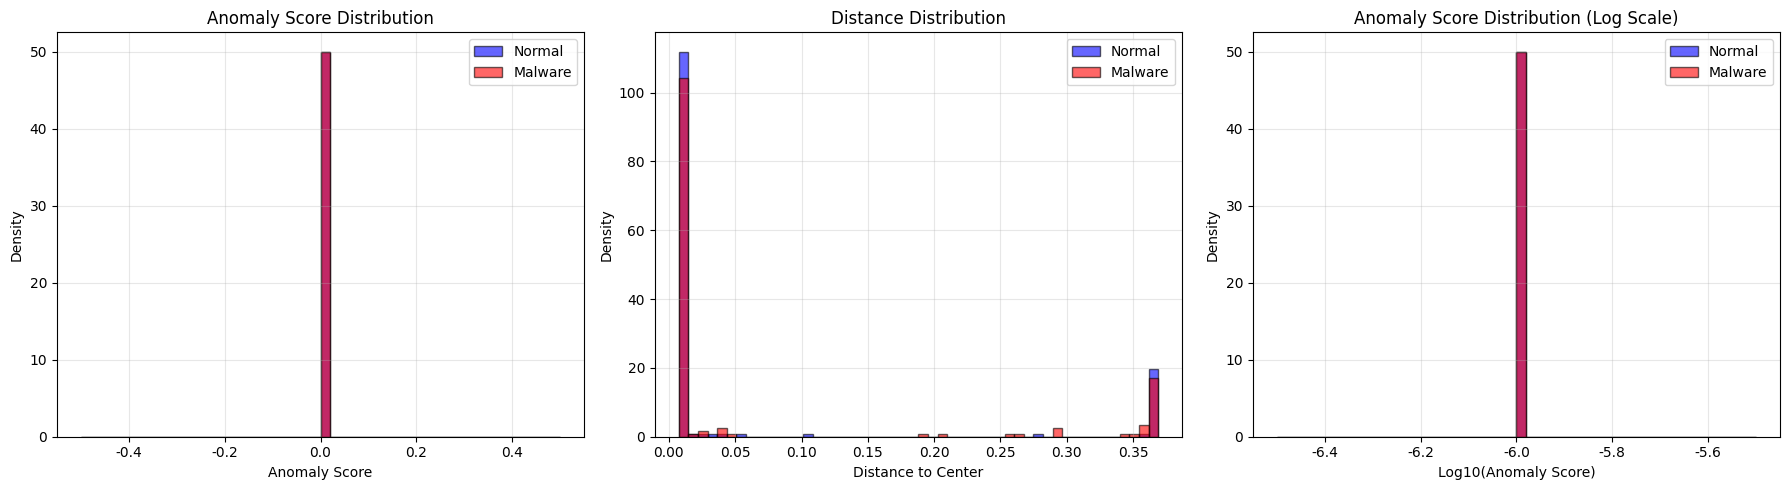


步骤3：寻找最佳检测阈值

方法1：Youden指数（最大化TPR-FPR）
  最佳阈值: inf
  TPR: 0.0000
  FPR: 0.0000
  Youden's J: 0.0000

方法2：最大化F1分数
  最佳阈值: 0.0000
  最大F1: 0.0000

方法3：基于Precision-Recall曲线
  最佳阈值: 0.0000

推荐使用阈值: inf

步骤4：使用最佳阈值进行检测

检测性能:
  准确率 (Accuracy):  0.5000 (50.00%)
  精确率 (Precision): 0.0000 (0.00%)
  召回率 (Recall):    0.0000 (0.00%)
  F1分数:             0.0000
  ROC-AUC:            0.5000

混淆矩阵:
  真负例 (TN):  162  |  假正例 (FP):    0
  假负例 (FN):  162  |  真正例 (TP):    0

详细指标:
  真正例率 (TPR/Recall):    0.0000
  真负例率 (TNR):           1.0000
  假正例率 (FPR):           0.0000
  假负例率 (FNR):           1.0000

步骤5：可视化评估结果


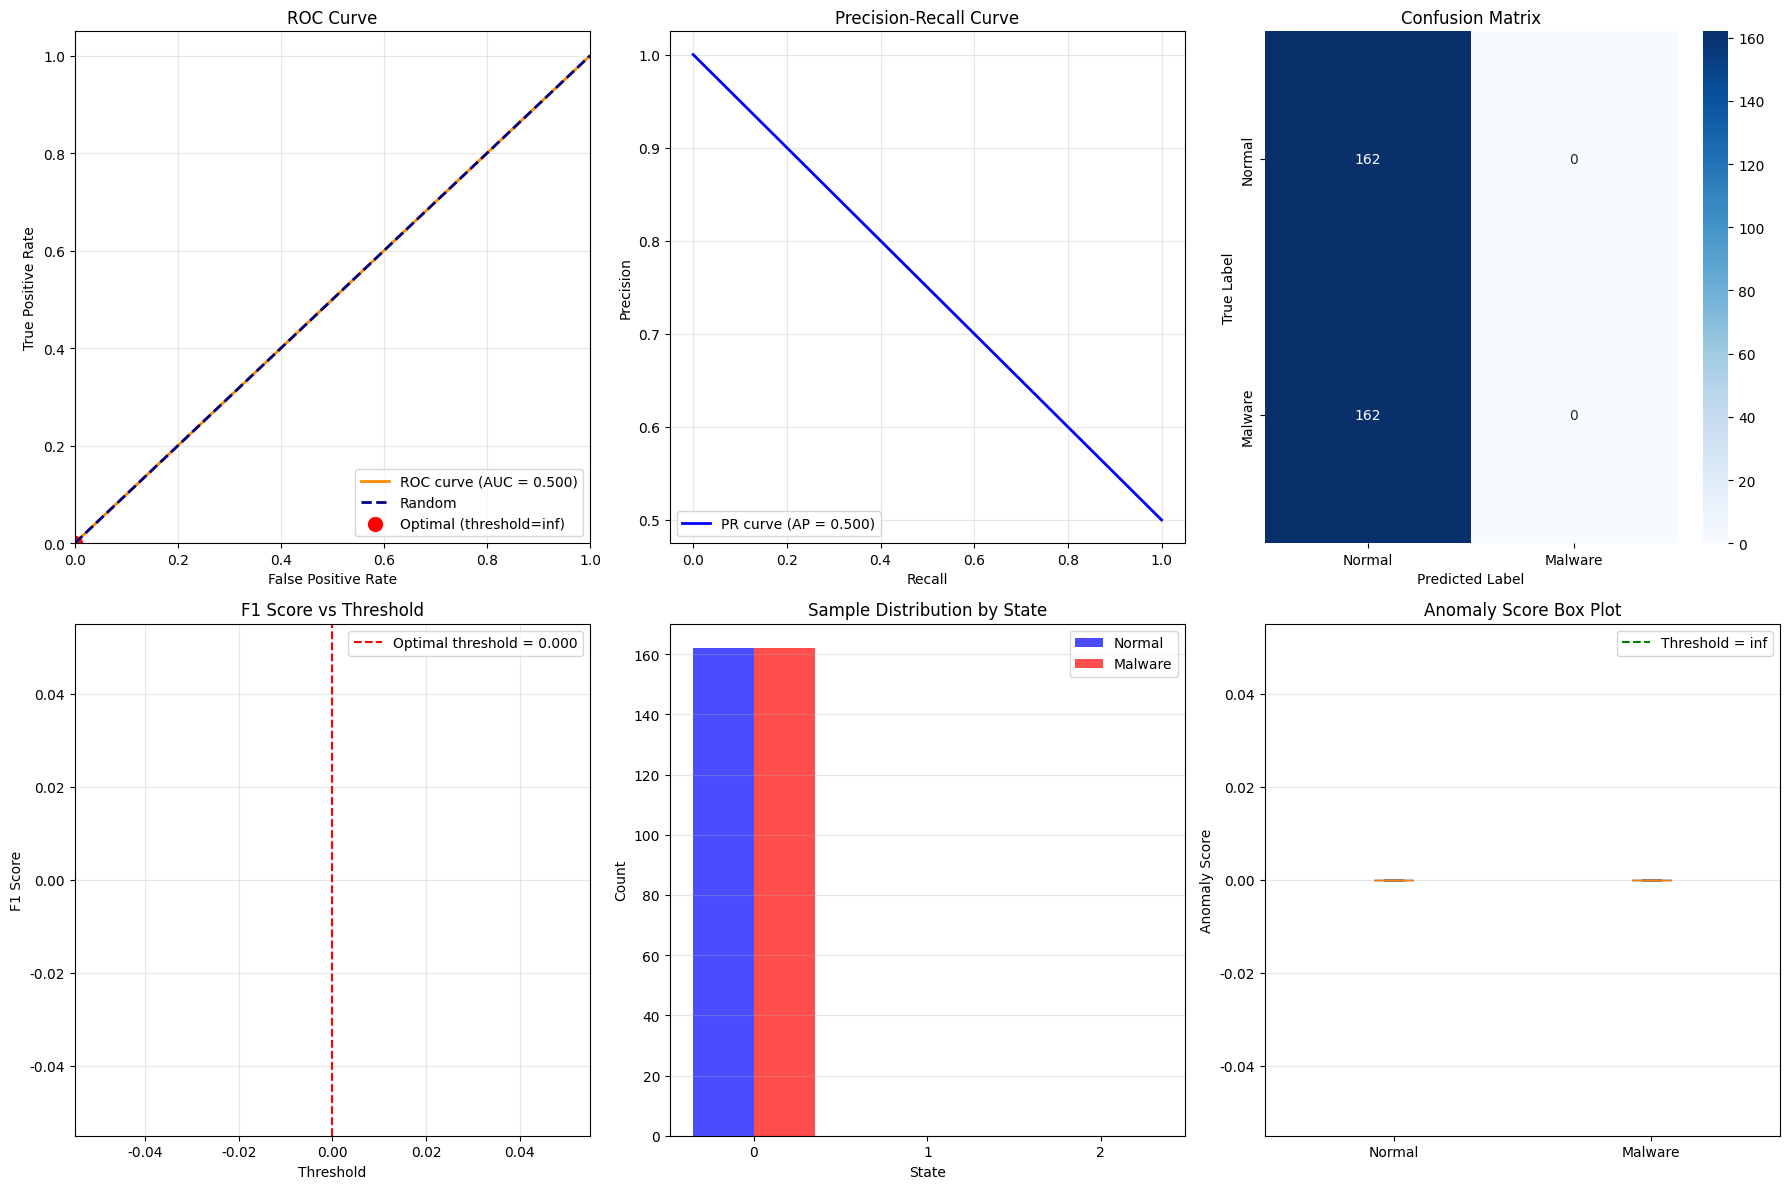


步骤6：误报和漏报分析

假正例（误报）: 0 个

假负例（漏报）: 162 个
  异常分数范围: [0.0000, 0.0000]
  平均异常分数: 0.0000

✓ 第五步完成！

🎉 全部流程完成！

最终总结:
  ✓ 数据集: 755 个正常样本用于训练
  ✓ 状态数: 3 个正常行为状态
  ✓ 检测准确率: 50.00%
  ✓ 精确率: 0.00%
  ✓ 召回率: 0.00%
  ✓ F1分数: 0.0000
  ✓ ROC-AUC: 0.5000

模型性能评价:
  ⚠️  模型还有改进空间


In [11]:
import warnings
warnings.filterwarnings('ignore')  # 过滤所有警告

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
import seaborn as sns

# ============================================================
# 第五步：测试集异常检测评估
# ============================================================

print("=" * 60)
print("第五步：测试集异常检测评估")
print("=" * 60)

# ============================================================
# 5.1: 在测试集上进行推理
# ============================================================

print("\n" + "=" * 60)
print("步骤1：在测试集上进行推理")
print("=" * 60)

model.eval()

# 存储结果
all_features = []
all_state_logits = []
all_predicted_states = []
all_distances = []
all_anomaly_scores = []
all_true_labels = []

# 创建测试数据集（不需要状态标签，我们会预测）
test_sequences = torch.LongTensor(X_test)

print(f"\n测试集大小: {len(test_sequences)}")
print(f"  正常样本: {(y_test == 0).sum()}")
print(f"  恶意样本: {(y_test == 1).sum()}")

# 批处理推理
batch_size = 64
n_batches = (len(test_sequences) + batch_size - 1) // batch_size

print(f"\n开始推理...")

with torch.no_grad():
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(test_sequences))

        batch_sequences = test_sequences[start_idx:end_idx].to(device)

        # 前向传播
        features, state_logits = model(batch_sequences)

        # 预测状态
        predicted_states = torch.argmax(state_logits, dim=1)

        # 计算异常分数
        anomaly_scores, distances = model.anomaly_score(features, predicted_states)

        # 保存结果
        all_features.append(features.cpu().numpy())
        all_state_logits.append(state_logits.cpu().numpy())
        all_predicted_states.append(predicted_states.cpu().numpy())
        all_distances.append(distances.cpu().numpy())
        all_anomaly_scores.append(anomaly_scores.cpu().numpy())

        if (i + 1) % 10 == 0 or i == n_batches - 1:
            print(f"  进度: {end_idx}/{len(test_sequences)}", end='\r')

print(f"  进度: {len(test_sequences)}/{len(test_sequences)} ✓")

# 合并结果
features_test = np.vstack(all_features)
state_logits_test = np.vstack(all_state_logits)
predicted_states_test = np.concatenate(all_predicted_states)
distances_test = np.concatenate(all_distances)
anomaly_scores_test = np.concatenate(all_anomaly_scores)

print(f"\n推理完成！")

# ============================================================
# 5.2: 分析异常分数分布
# ============================================================

print("\n" + "=" * 60)
print("步骤2：分析异常分数分布")
print("=" * 60)

# 按真实标签分组
normal_mask = (y_test == 0)
malware_mask = (y_test == 1)

scores_normal = anomaly_scores_test[normal_mask]
scores_malware = anomaly_scores_test[malware_mask]

distances_normal = distances_test[normal_mask]
distances_malware = distances_test[malware_mask]

print(f"\n正常样本异常分数:")
print(f"  均值: {scores_normal.mean():.4f}")
print(f"  标准差: {scores_normal.std():.4f}")
print(f"  中位数: {np.median(scores_normal):.4f}")
print(f"  最大值: {scores_normal.max():.4f}")

print(f"\n恶意样本异常分数:")
print(f"  均值: {scores_malware.mean():.4f}")
print(f"  标准差: {scores_malware.std():.4f}")
print(f"  中位数: {np.median(scores_malware):.4f}")
print(f"  最小值: {scores_malware.min():.4f}")

print(f"\n分数差异: {scores_malware.mean() - scores_normal.mean():.4f}")

# 可视化分布
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 子图1：异常分数分布
axes[0].hist(scores_normal, bins=50, alpha=0.6, label='Normal',
            color='blue', edgecolor='black', density=True)
axes[0].hist(scores_malware, bins=50, alpha=0.6, label='Malware',
            color='red', edgecolor='black', density=True)
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Anomaly Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 子图2：距离分布
axes[1].hist(distances_normal, bins=50, alpha=0.6, label='Normal',
            color='blue', edgecolor='black', density=True)
axes[1].hist(distances_malware, bins=50, alpha=0.6, label='Malware',
            color='red', edgecolor='black', density=True)
axes[1].set_xlabel('Distance to Center')
axes[1].set_ylabel('Density')
axes[1].set_title('Distance Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 子图3：对数尺度的异常分数（便于观察）
axes[2].hist(np.log10(scores_normal + 1e-6), bins=50, alpha=0.6,
            label='Normal', color='blue', edgecolor='black', density=True)
axes[2].hist(np.log10(scores_malware + 1e-6), bins=50, alpha=0.6,
            label='Malware', color='red', edgecolor='black', density=True)
axes[2].set_xlabel('Log10(Anomaly Score)')
axes[2].set_ylabel('Density')
axes[2].set_title('Anomaly Score Distribution (Log Scale)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 5.3: 寻找最佳阈值
# ============================================================

print("\n" + "=" * 60)
print("步骤3：寻找最佳检测阈值")
print("=" * 60)

# 方法1：基于ROC曲线的Youden指数
fpr, tpr, thresholds_roc = roc_curve(y_test, anomaly_scores_test)
roc_auc = auc(fpr, tpr)

# Youden's J statistic = TPR - FPR
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_youden = thresholds_roc[optimal_idx]

print(f"\n方法1：Youden指数（最大化TPR-FPR）")
print(f"  最佳阈值: {optimal_threshold_youden:.4f}")
print(f"  TPR: {tpr[optimal_idx]:.4f}")
print(f"  FPR: {fpr[optimal_idx]:.4f}")
print(f"  Youden's J: {j_scores[optimal_idx]:.4f}")

# 方法2：基于F1分数
from sklearn.metrics import f1_score

threshold_range = np.linspace(
    anomaly_scores_test.min(),
    anomaly_scores_test.max(),
    100
)

f1_scores = []
for thresh in threshold_range:
    predictions = (anomaly_scores_test > thresh).astype(int)
    f1 = f1_score(y_test, predictions)
    f1_scores.append(f1)

optimal_threshold_f1 = threshold_range[np.argmax(f1_scores)]

print(f"\n方法2：最大化F1分数")
print(f"  最佳阈值: {optimal_threshold_f1:.4f}")
print(f"  最大F1: {max(f1_scores):.4f}")

# 方法3：基于精确率和召回率的平衡
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(
    y_test, anomaly_scores_test
)

# F-beta score with beta=1 (equal weight to precision and recall)
f_beta = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-10)
optimal_threshold_pr = thresholds_pr[np.argmax(f_beta)]

print(f"\n方法3：基于Precision-Recall曲线")
print(f"  最佳阈值: {optimal_threshold_pr:.4f}")

# 选择推荐阈值（使用Youden方法）
optimal_threshold = optimal_threshold_youden

print(f"\n推荐使用阈值: {optimal_threshold:.4f}")

# ============================================================
# 5.4: 使用最佳阈值进行预测
# ============================================================

print("\n" + "=" * 60)
print("步骤4：使用最佳阈值进行检测")
print("=" * 60)

predictions = (anomaly_scores_test > optimal_threshold).astype(int)

# 计算各项指标
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"\n检测性能:")
print(f"  准确率 (Accuracy):  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  精确率 (Precision): {precision:.4f} ({precision*100:.2f}%)")
print(f"  召回率 (Recall):    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1分数:             {f1:.4f}")
print(f"  ROC-AUC:            {roc_auc:.4f}")

# 混淆矩阵
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

print(f"\n混淆矩阵:")
print(f"  真负例 (TN): {tn:4d}  |  假正例 (FP): {fp:4d}")
print(f"  假负例 (FN): {fn:4d}  |  真正例 (TP): {tp:4d}")

print(f"\n详细指标:")
print(f"  真正例率 (TPR/Recall):    {tp/(tp+fn):.4f}")
print(f"  真负例率 (TNR):           {tn/(tn+fp):.4f}")
print(f"  假正例率 (FPR):           {fp/(fp+tn):.4f}")
print(f"  假负例率 (FNR):           {fn/(fn+tp):.4f}")

# ============================================================
# 5.5: 可视化评估结果
# ============================================================

print("\n" + "=" * 60)
print("步骤5：可视化评估结果")
print("=" * 60)

fig = plt.figure(figsize=(18, 12))

# 子图1：ROC曲线
ax1 = plt.subplot(2, 3, 1)
ax1.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100,
           marker='o', label=f'Optimal (threshold={optimal_threshold:.3f})')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 子图2：Precision-Recall曲线
ax2 = plt.subplot(2, 3, 2)
ap = average_precision_score(y_test, anomaly_scores_test)
ax2.plot(recall_vals, precision_vals, color='blue', lw=2,
        label=f'PR curve (AP = {ap:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 子图3：混淆矩阵
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
           xticklabels=['Normal', 'Malware'],
           yticklabels=['Normal', 'Malware'])
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')
ax3.set_title('Confusion Matrix')

# 子图4：阈值 vs F1分数
ax4 = plt.subplot(2, 3, 4)
ax4.plot(threshold_range, f1_scores, 'g-', lw=2)
ax4.axvline(optimal_threshold_f1, color='red', linestyle='--',
           label=f'Optimal threshold = {optimal_threshold_f1:.3f}')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('F1 Score')
ax4.set_title('F1 Score vs Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 子图5：按状态的检测性能
ax5 = plt.subplot(2, 3, 5)
states_normal = predicted_states_test[normal_mask]
states_malware = predicted_states_test[malware_mask]

x = np.arange(optimal_k)
width = 0.35

counts_normal = [np.sum(states_normal == i) for i in range(optimal_k)]
counts_malware = [np.sum(states_malware == i) for i in range(optimal_k)]

ax5.bar(x - width/2, counts_normal, width, label='Normal',
       color='blue', alpha=0.7)
ax5.bar(x + width/2, counts_malware, width, label='Malware',
       color='red', alpha=0.7)
ax5.set_xlabel('State')
ax5.set_ylabel('Count')
ax5.set_title('Sample Distribution by State')
ax5.set_xticks(x)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 子图6：异常分数箱线图
ax6 = plt.subplot(2, 3, 6)
data_to_plot = [scores_normal, scores_malware]
bp = ax6.boxplot(data_to_plot, labels=['Normal', 'Malware'],
                patch_artist=True, showfliers=False)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('red')
ax6.axhline(optimal_threshold, color='green', linestyle='--',
           label=f'Threshold = {optimal_threshold:.3f}')
ax6.set_ylabel('Anomaly Score')
ax6.set_title('Anomaly Score Box Plot')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================
# 5.6: 误报和漏报分析
# ============================================================

print("\n" + "=" * 60)
print("步骤6：误报和漏报分析")
print("=" * 60)

# 找出误报样本（假正例）
fp_indices = np.where((y_test == 0) & (predictions == 1))[0]
print(f"\n假正例（误报）: {len(fp_indices)} 个")
if len(fp_indices) > 0:
    print(f"  异常分数范围: [{anomaly_scores_test[fp_indices].min():.4f}, "
          f"{anomaly_scores_test[fp_indices].max():.4f}]")
    print(f"  平均异常分数: {anomaly_scores_test[fp_indices].mean():.4f}")

# 找出漏报样本（假负例）
fn_indices = np.where((y_test == 1) & (predictions == 0))[0]
print(f"\n假负例（漏报）: {len(fn_indices)} 个")
if len(fn_indices) > 0:
    print(f"  异常分数范围: [{anomaly_scores_test[fn_indices].min():.4f}, "
          f"{anomaly_scores_test[fn_indices].max():.4f}]")
    print(f"  平均异常分数: {anomaly_scores_test[fn_indices].mean():.4f}")

print("\n" + "=" * 60)
print("✓ 第五步完成！")
print("=" * 60)

print("\n" + "=" * 60)
print("🎉 全部流程完成！")
print("=" * 60)

print(f"\n最终总结:")
print(f"  ✓ 数据集: {len(X_train_normal)} 个正常样本用于训练")
print(f"  ✓ 状态数: {optimal_k} 个正常行为状态")
print(f"  ✓ 检测准确率: {accuracy*100:.2f}%")
print(f"  ✓ 精确率: {precision*100:.2f}%")
print(f"  ✓ 召回率: {recall*100:.2f}%")
print(f"  ✓ F1分数: {f1:.4f}")
print(f"  ✓ ROC-AUC: {roc_auc:.4f}")

print(f"\n模型性能评价:")
if roc_auc >= 0.9:
    print("  🌟🌟🌟 优秀！模型检测性能很好")
elif roc_auc >= 0.8:
    print("  🌟🌟 良好！模型有实用价值")
else:
    print("  ⚠️  模型还有改进空间")


问题诊断：恶意软件距离分析



正常样本距离:
  均值: 0.0646
  标准差: 0.1287
  最小值: 0.0075
  最大值: 0.3688

恶意样本距离:
  均值: 0.0777
  标准差: 0.1358
  最小值: 0.0075
  最大值: 0.3688

各状态的半径:
  状态 0: 0.5868
  状态 1: 0.6642
  状态 2: 0.6021


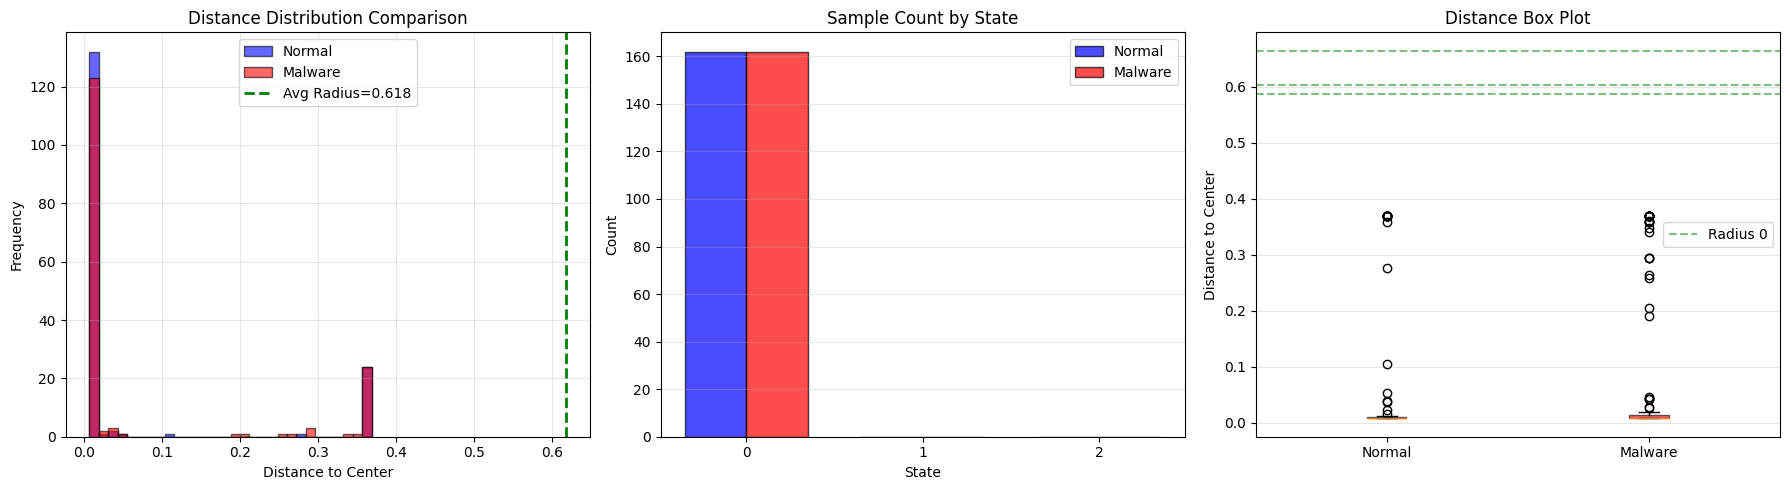


超出半径的样本统计:
  状态 0 - 正常样本超出: 0/162
  状态 0 - 恶意样本超出: 0/162

诊断完成


In [12]:
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 诊断：检查恶意软件的实际距离
# ============================================================

print("=" * 60)
print("问题诊断：恶意软件距离分析")
print("=" * 60)

model.eval()

# 分别计算正常和恶意样本的距离
distances_by_label = {0: [], 1: []}
states_by_label = {0: [], 1: []}

with torch.no_grad():
    for i in range(len(X_test)):
        seq = torch.LongTensor(X_test[i:i+1]).to(device)
        label = y_test[i]

        features, state_logits = model(seq)
        predicted_state = torch.argmax(state_logits, dim=1)

        distances, _ = model.compute_distances(features, predicted_state)

        distances_by_label[label].append(distances.item())
        states_by_label[label].append(predicted_state.item())

distances_normal = np.array(distances_by_label[0])
distances_malware = np.array(distances_by_label[1])
states_normal = np.array(states_by_label[0])
states_malware = np.array(states_by_label[1])

print(f"\n正常样本距离:")
print(f"  均值: {distances_normal.mean():.4f}")
print(f"  标准差: {distances_normal.std():.4f}")
print(f"  最小值: {distances_normal.min():.4f}")
print(f"  最大值: {distances_normal.max():.4f}")

print(f"\n恶意样本距离:")
print(f"  均值: {distances_malware.mean():.4f}")
print(f"  标准差: {distances_malware.std():.4f}")
print(f"  最小值: {distances_malware.min():.4f}")
print(f"  最大值: {distances_malware.max():.4f}")

print(f"\n各状态的半径:")
final_radius = model.get_radius().detach().cpu().numpy()
for i in range(len(final_radius)):
    print(f"  状态 {i}: {final_radius[i]:.4f}")

# 可视化距离对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 子图1：距离分布对比
axes[0].hist(distances_normal, bins=30, alpha=0.6, label='Normal',
            color='blue', edgecolor='black')
axes[0].hist(distances_malware, bins=30, alpha=0.6, label='Malware',
            color='red', edgecolor='black')
axes[0].axvline(final_radius.mean(), color='green', linestyle='--',
               linewidth=2, label=f'Avg Radius={final_radius.mean():.3f}')
axes[0].set_xlabel('Distance to Center')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Distribution Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 子图2：状态分布
state_counts_normal = [np.sum(states_normal == i) for i in range(optimal_k)]
state_counts_malware = [np.sum(states_malware == i) for i in range(optimal_k)]

x = np.arange(optimal_k)
width = 0.35
axes[1].bar(x - width/2, state_counts_normal, width, label='Normal',
           color='blue', alpha=0.7, edgecolor='black')
axes[1].bar(x + width/2, state_counts_malware, width, label='Malware',
           color='red', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Count')
axes[1].set_title('Sample Count by State')
axes[1].set_xticks(x)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# 子图3：箱线图
data_plot = [distances_normal, distances_malware]
bp = axes[2].boxplot(data_plot, labels=['Normal', 'Malware'],
                     patch_artist=True, showfliers=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('red')
bp['boxes'][1].set_alpha(0.6)

# 添加半径线
for i, r in enumerate(final_radius):
    axes[2].axhline(r, color='green', linestyle='--', alpha=0.5,
                   label=f'Radius {i}' if i == 0 else None)

axes[2].set_ylabel('Distance to Center')
axes[2].set_title('Distance Box Plot')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].legend()

plt.tight_layout()
plt.show()

# 统计有多少恶意样本超出半径
print(f"\n超出半径的样本统计:")
for i in range(optimal_k):
    mask_normal = (states_normal == i)
    mask_malware = (states_malware == i)

    if np.sum(mask_normal) > 0:
        normal_out = np.sum(distances_normal[mask_normal] > final_radius[i])
        print(f"  状态 {i} - 正常样本超出: {normal_out}/{np.sum(mask_normal)}")

    if np.sum(mask_malware) > 0:
        malware_out = np.sum(distances_malware[mask_malware] > final_radius[i])
        print(f"  状态 {i} - 恶意样本超出: {malware_out}/{np.sum(mask_malware)}")

print("\n" + "=" * 60)
print("诊断完成")
print("=" * 60)


In [13]:
# ============================================================
# 方案A：改进的HMM-Deep SVDD模型（修复版本）
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedHMMDeepSVDD(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_states, feature_dim):
        super(ImprovedHMMDeepSVDD, self).__init__()

        self.num_states = num_states
        self.feature_dim = feature_dim

        # API嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM特征提取器（双向）
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=2, batch_first=True,
                           dropout=0.3, bidirectional=True)

        # 状态预测器（使用双向LSTM的输出）
        self.state_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_states)
        )

        # 特征投影器（到Deep SVDD空间）
        self.feature_projector = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, feature_dim)
        )

        # 每个状态的超球中心（可学习）
        self.centers = nn.Parameter(torch.randn(num_states, feature_dim))

        # 半径（使用log空间，确保正数）
        self.log_radius = nn.Parameter(torch.zeros(num_states))

    def forward(self, x):
        # 嵌入 + LSTM
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        # 使用最后一个时间步
        last_hidden = lstm_out[:, -1, :]

        # 状态预测
        state_logits = self.state_predictor(last_hidden)

        # 特征提取
        features = self.feature_projector(last_hidden)

        return features, state_logits

    def compute_distances(self, features, predicted_states):
        """计算特征到对应状态中心的距离"""
        batch_size = features.size(0)
        distances = torch.zeros(batch_size, device=features.device)

        for i in range(batch_size):
            state = predicted_states[i]
            center = self.centers[state]
            distances[i] = torch.sum((features[i] - center) ** 2)

        return distances, self.centers

    def get_radius(self):
        """获取半径（确保正数）"""
        return torch.exp(self.log_radius)


# ============================================================
# 改进的训练函数（修复版本）
# ============================================================

def train_improved_model(model, train_loader, val_loader,
                        epochs=50, lr=1e-3, device='cuda'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # 修复：去掉verbose参数
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # 损失权重
    alpha = 1.0    # SVDD损失权重
    beta = 0.5     # 状态预测损失权重
    gamma = 0.3    # 对比损失权重
    delta = 0.2    # 状态多样性损失权重

    history = {'train_loss': [], 'val_loss': [], 'val_distances': []}
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # ========== 训练阶段 ==========
        model.train()
        train_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # 前向传播
            features, state_logits = model(batch_x)
            predicted_states = torch.argmax(state_logits, dim=1)

            # 1. SVDD损失（只用正常样本）
            normal_mask = (batch_y == 0)
            if normal_mask.sum() > 0:
                normal_features = features[normal_mask]
                normal_states = predicted_states[normal_mask]
                distances, _ = model.compute_distances(normal_features, normal_states)
                svdd_loss = distances.mean()
            else:
                svdd_loss = torch.tensor(0.0, device=device)

            # 2. 状态预测损失（鼓励状态多样性）
            # 使用softmax温度来平衡状态分布
            state_probs = F.softmax(state_logits / 0.5, dim=1)
            state_entropy = -torch.sum(state_probs * torch.log(state_probs + 1e-10), dim=1)
            state_loss = -state_entropy.mean()  # 负熵 = 鼓励集中

            # 3. 对比损失（拉开正常和异常样本）
            if normal_mask.sum() > 0 and (~normal_mask).sum() > 0:
                normal_features = features[normal_mask]
                malware_features = features[~normal_mask]

                # 计算正常样本到中心的距离（越小越好）
                normal_states = predicted_states[normal_mask]
                normal_dist, _ = model.compute_distances(normal_features, normal_states)

                # 计算恶意样本到中心的距离（越大越好）
                malware_states = predicted_states[~normal_mask]
                malware_dist, _ = model.compute_distances(malware_features, malware_states)

                # Margin-based对比损失
                margin = 0.5
                contrastive_loss = F.relu(margin + normal_dist.mean() - malware_dist.mean())
            else:
                contrastive_loss = torch.tensor(0.0, device=device)

            # 4. 状态多样性损失（鼓励样本分散到不同状态）
            state_counts = torch.bincount(predicted_states, minlength=model.num_states).float()
            state_distribution = state_counts / state_counts.sum()
            uniform_distribution = torch.ones_like(state_distribution) / model.num_states
            diversity_loss = F.kl_div(
                torch.log(state_distribution + 1e-10),
                uniform_distribution,
                reduction='batchmean'
            )

            # 总损失
            loss = (alpha * svdd_loss +
                   beta * state_loss +
                   gamma * contrastive_loss +
                   delta * diversity_loss)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ========== 验证阶段 ==========
        model.eval()
        val_loss = 0.0
        all_distances = []
        all_states = []
        all_labels = []

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                features, state_logits = model(batch_x)
                predicted_states = torch.argmax(state_logits, dim=1)

                # 只计算SVDD损失
                normal_mask = (batch_y == 0)
                if normal_mask.sum() > 0:
                    normal_features = features[normal_mask]
                    normal_states = predicted_states[normal_mask]
                    distances, _ = model.compute_distances(normal_features, normal_states)
                    val_loss += distances.mean().item()

                # 收集所有样本的距离
                all_dist, _ = model.compute_distances(features, predicted_states)
                all_distances.extend(all_dist.cpu().numpy())
                all_states.extend(predicted_states.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        # 获取当前学习率
        current_lr = optimizer.param_groups[0]['lr']

        # 更新学习率
        old_lr = current_lr
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # 手动打印学习率变化
        if new_lr != old_lr:
            print(f"  Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        # 动态调整半径（关键改进！）
        if epoch % 5 == 0 and epoch > 0:
            with torch.no_grad():
                for state_id in range(model.num_states):
                    state_mask = np.array(all_states) == state_id
                    state_normal_mask = state_mask & (np.array(all_labels) == 0)

                    if state_normal_mask.sum() > 0:
                        state_distances = np.array(all_distances)[state_normal_mask]
                        # 使用95分位数作为半径
                        new_radius = np.percentile(state_distances, 95)
                        model.log_radius.data[state_id] = torch.log(
                            torch.tensor(new_radius + 0.01, device=device)
                        )

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_distances'].append(all_distances)

        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_improved_model.pth')

        # 打印进度
        if epoch % 5 == 0:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}")
            print(f"  Learning Rate: {current_lr:.6f}")

            # 打印状态分布
            unique_states, state_counts = np.unique(all_states, return_counts=True)
            print(f"  State Distribution: {dict(zip(unique_states, state_counts))}")

            # 打印半径
            radius = model.get_radius().detach().cpu().numpy()
            print(f"  Radius: {radius}")

            # 打印距离统计
            normal_distances = np.array(all_distances)[np.array(all_labels) == 0]
            malware_distances = np.array(all_distances)[np.array(all_labels) == 1]
            print(f"  Normal distances: mean={normal_distances.mean():.4f}, max={normal_distances.max():.4f}")
            print(f"  Malware distances: mean={malware_distances.mean():.4f}, max={malware_distances.max():.4f}")

    return history


# ============================================================
# 使用改进模型
# ============================================================

print("=" * 60)
print("训练改进的HMM-Deep SVDD模型")
print("=" * 60)

# 创建改进模型
improved_model = ImprovedHMMDeepSVDD(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_states=optimal_k,
    feature_dim=64
).to(device)

# 训练
history_improved = train_improved_model(
    improved_model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    device=device
)

print("\n" + "=" * 60)
print("训练完成！")
print("=" * 60)


训练改进的HMM-Deep SVDD模型

Epoch 1/50
  Train Loss: 68.1047
  Val Loss: 56.5270
  Learning Rate: 0.001000
  State Distribution: {np.int64(1): np.int64(138), np.int64(2): np.int64(24)}
  Radius: [1. 1. 1.]
  Normal distances: mean=56.5130, max=60.8740
  Malware distances: mean=54.2067, max=58.0954

Epoch 6/50
  Train Loss: 46.4950
  Val Loss: 43.8516
  Learning Rate: 0.001000
  State Distribution: {np.int64(0): np.int64(97), np.int64(2): np.int64(65)}
  Radius: [57.501568  1.       26.520693]
  Normal distances: mean=44.3903, max=57.6076
  Malware distances: mean=25.9783, max=26.1071
  Learning rate reduced: 0.001000 -> 0.000500

Epoch 11/50
  Train Loss: 40.5492
  Val Loss: 41.3845
  Learning Rate: 0.000500
  State Distribution: {np.int64(0): np.int64(56), np.int64(1): np.int64(31), np.int64(2): np.int64(75)}
  Radius: [50.004494 64.4559   24.851233]
  Normal distances: mean=40.7830, max=64.4551
  Malware distances: mean=23.8358, max=24.0148

Epoch 16/50
  Train Loss: 36.5119
  Val Loss: 43

测试改进模型



测试集距离统计（按标签）:
  正常样本:
    数量: 162
    距离 - 均值: 18.4359, 标准差: 7.3888
    距离 - 最小值: 13.3937, 最大值: 40.9757
    异常分数 - 均值: 0.0000
    异常分数 - 最大值: 0.0069
  恶意样本:
    数量: 162
    距离 - 均值: 22.4517, 标准差: 10.2931
    距离 - 最小值: 14.3038, 最大值: 42.5459
    异常分数 - 均值: 0.0003
    异常分数 - 最大值: 0.0455

各状态的半径:
  状态 0: 40.6294
  状态 1: 40.6936
  状态 2: 17.5383

性能评估（使用异常分数）

阈值 = 0.0:
  Accuracy:  0.5062
  Precision: 0.7500
  Recall:    0.0185
  F1-Score:  0.0361
  TP=3, FP=1, TN=161, FN=159

阈值 = 0.1:
  Accuracy:  0.5000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  TP=0, FP=0, TN=162, FN=162

阈值 = 0.5:
  Accuracy:  0.5000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  TP=0, FP=0, TN=162, FN=162

阈值 = 1.0:
  Accuracy:  0.5000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  TP=0, FP=0, TN=162, FN=162

阈值 = 2.0:
  Accuracy:  0.5000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  TP=0, FP=0, TN=162, FN=162

最佳阈值: 0.0, F1-Score: 0.0361


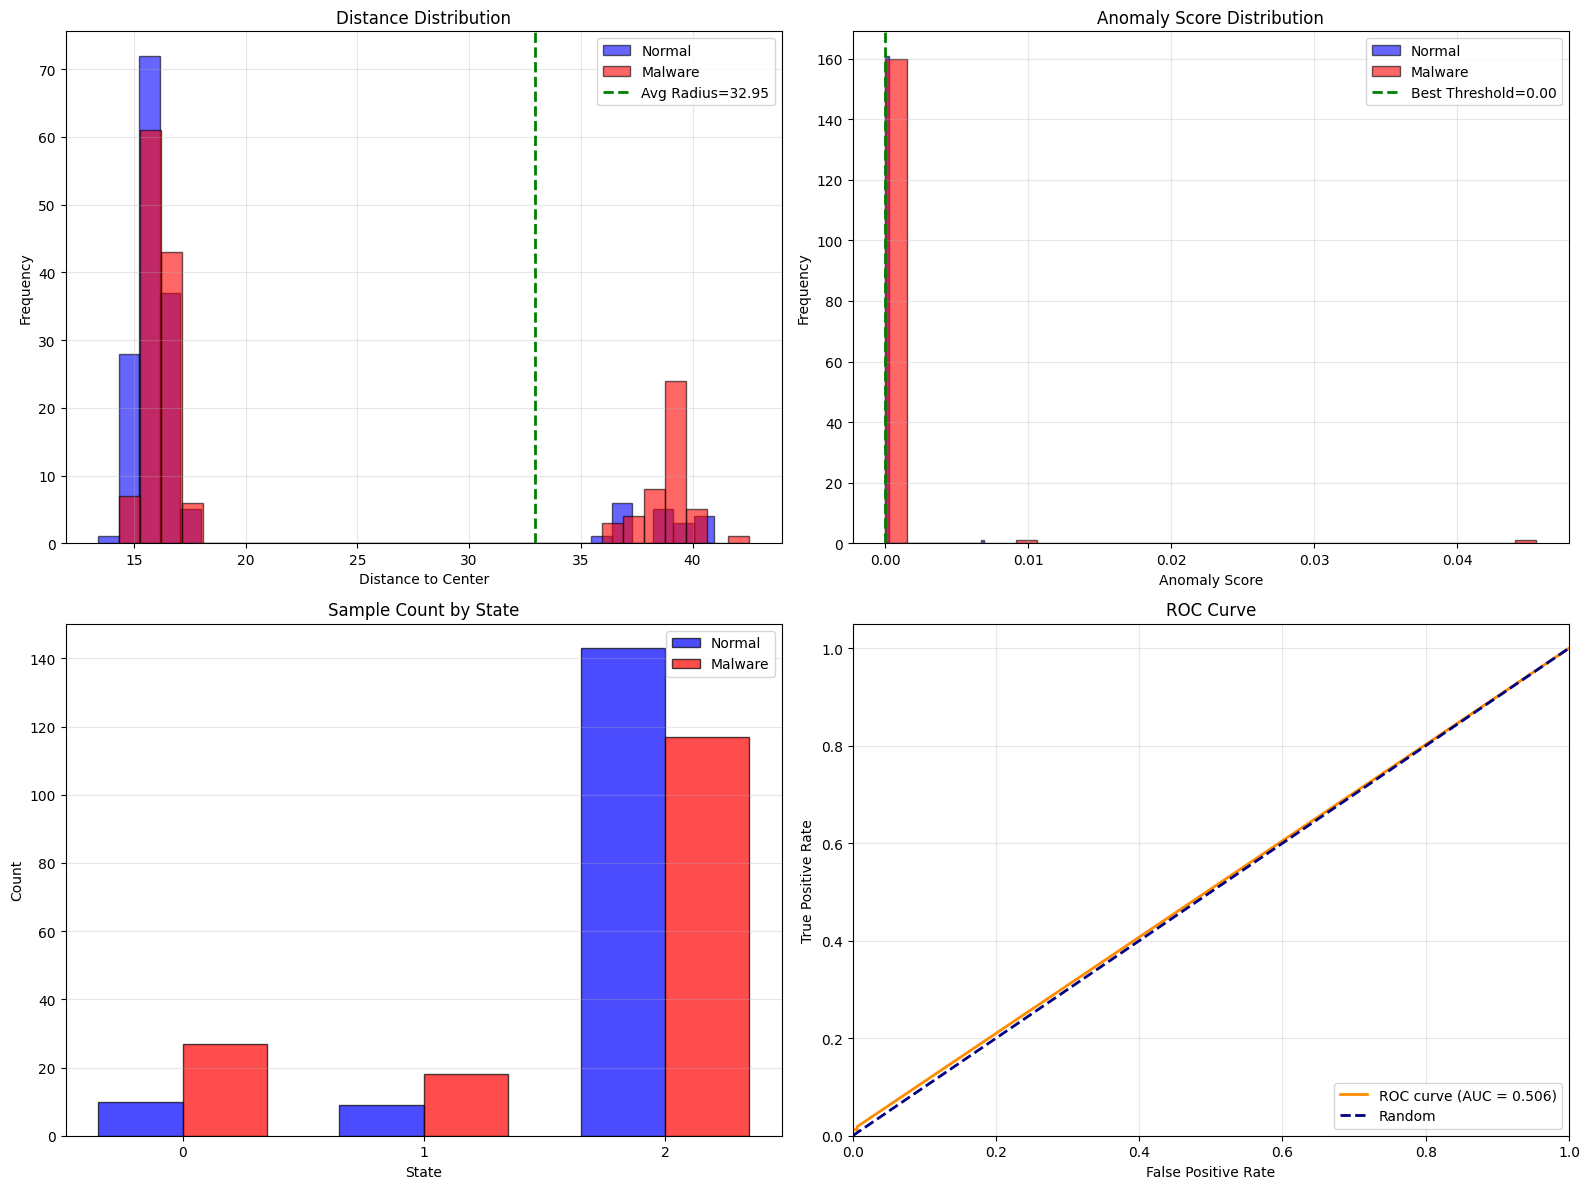


测试完成


In [14]:
# ============================================================
# 测试改进模型的性能
# ============================================================

import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("测试改进模型")
print("=" * 60)

# 加载最佳模型
improved_model.load_state_dict(torch.load('best_improved_model.pth'))
improved_model.eval()

# 在测试集上评估
test_results = []
test_labels = []
test_distances = []
test_states = []
test_anomaly_scores = []

final_radius = improved_model.get_radius().detach().cpu().numpy()

with torch.no_grad():
    for i in range(len(X_test)):
        seq = torch.LongTensor(X_test[i:i+1]).to(device)
        label = y_test[i]

        features, state_logits = improved_model(seq)
        predicted_state = torch.argmax(state_logits, dim=1)

        distances, _ = improved_model.compute_distances(features, predicted_state)
        distance = distances.item()
        state = predicted_state.item()

        # 计算异常分数
        anomaly_score = max(0, distance - final_radius[state]) / (final_radius[state] + 1e-6)

        test_results.append({
            'label': label,
            'distance': distance,
            'state': state,
            'radius': final_radius[state],
            'anomaly_score': anomaly_score
        })

        test_labels.append(label)
        test_distances.append(distance)
        test_states.append(state)
        test_anomaly_scores.append(anomaly_score)

# 转换为数组
test_labels = np.array(test_labels)
test_distances = np.array(test_distances)
test_anomaly_scores = np.array(test_anomaly_scores)

# 打印详细统计
print("\n测试集距离统计（按标签）:")
for label in [0, 1]:
    mask = test_labels == label
    label_name = "正常" if label == 0 else "恶意"
    print(f"  {label_name}样本:")
    print(f"    数量: {mask.sum()}")
    print(f"    距离 - 均值: {test_distances[mask].mean():.4f}, 标准差: {test_distances[mask].std():.4f}")
    print(f"    距离 - 最小值: {test_distances[mask].min():.4f}, 最大值: {test_distances[mask].max():.4f}")
    print(f"    异常分数 - 均值: {test_anomaly_scores[mask].mean():.4f}")
    print(f"    异常分数 - 最大值: {test_anomaly_scores[mask].max():.4f}")

print(f"\n各状态的半径:")
for i, r in enumerate(final_radius):
    print(f"  状态 {i}: {r:.4f}")

# 计算评估指标（使用不同阈值）
print("\n" + "=" * 60)
print("性能评估（使用异常分数）")
print("=" * 60)

# 尝试多个阈值
thresholds = [0.0, 0.1, 0.5, 1.0, 2.0]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (test_anomaly_scores > threshold).astype(int)

    tp = np.sum((y_pred == 1) & (test_labels == 1))
    fp = np.sum((y_pred == 1) & (test_labels == 0))
    tn = np.sum((y_pred == 0) & (test_labels == 0))
    fn = np.sum((y_pred == 0) & (test_labels == 1))

    accuracy = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n阈值 = {threshold:.1f}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  TP={tp}, FP={fp}, TN={tn}, FN={fn}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n最佳阈值: {best_threshold:.1f}, F1-Score: {best_f1:.4f}")

# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1：距离分布对比
normal_mask = test_labels == 0
malware_mask = test_labels == 1

axes[0, 0].hist(test_distances[normal_mask], bins=30, alpha=0.6,
               label='Normal', color='blue', edgecolor='black')
axes[0, 0].hist(test_distances[malware_mask], bins=30, alpha=0.6,
               label='Malware', color='red', edgecolor='black')
axes[0, 0].axvline(final_radius.mean(), color='green', linestyle='--',
                  linewidth=2, label=f'Avg Radius={final_radius.mean():.2f}')
axes[0, 0].set_xlabel('Distance to Center')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distance Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 子图2：异常分数分布
axes[0, 1].hist(test_anomaly_scores[normal_mask], bins=30, alpha=0.6,
               label='Normal', color='blue', edgecolor='black')
axes[0, 1].hist(test_anomaly_scores[malware_mask], bins=30, alpha=0.6,
               label='Malware', color='red', edgecolor='black')
axes[0, 1].axvline(best_threshold, color='green', linestyle='--',
                  linewidth=2, label=f'Best Threshold={best_threshold:.2f}')
axes[0, 1].set_xlabel('Anomaly Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Anomaly Score Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 子图3：状态分布
state_counts_normal = [np.sum((test_states == np.array(test_states)) & normal_mask & (np.array(test_states) == i))
                       for i in range(optimal_k)]
state_counts_malware = [np.sum((test_states == np.array(test_states)) & malware_mask & (np.array(test_states) == i))
                        for i in range(optimal_k)]

x = np.arange(optimal_k)
width = 0.35
axes[1, 0].bar(x - width/2, state_counts_normal, width, label='Normal',
              color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x + width/2, state_counts_malware, width, label='Malware',
              color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Sample Count by State')
axes[1, 0].set_xticks(x)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4：ROC曲线
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, test_anomaly_scores)
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("测试完成")
print("=" * 60)


In [16]:
# ============================================================
# 数据诊断：检查可用变量并进行API调用模式分析
# ============================================================

print("=" * 60)
print("数据诊断：API调用模式分析")
print("=" * 60)

# 首先，让我们重新构建训练数据
# 从train_loader和test_loader中提取数据

print("\n正在从DataLoader中提取数据...")

# 提取训练数据
X_train_list = []
y_train_list = []

for batch_x, batch_y in train_loader:
    X_train_list.extend(batch_x.cpu().numpy())
    y_train_list.extend(batch_y.cpu().numpy())

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# 提取测试数据
X_test_list = []
y_test_list = []

for batch_x, batch_y in test_loader:
    X_test_list.extend(batch_x.cpu().numpy())
    y_test_list.extend(batch_y.cpu().numpy())

X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

# 1. 检查API词汇表的使用频率
from collections import Counter

# 统计正常和恶意样本的API使用
normal_apis = []
malware_apis = []

for i in range(len(X_train)):
    apis = [api for api in X_train[i] if api != 0]  # 去掉padding
    if y_train[i] == 0:
        normal_apis.extend(apis)
    else:
        malware_apis.extend(apis)

normal_counter = Counter(normal_apis)
malware_counter = Counter(malware_apis)

print("\n正常样本统计:")
print(f"  总API调用数: {len(normal_apis)}")
print(f"  唯一API数: {len(normal_counter)}")
print(f"  Top 10 APIs:")
for api_id, count in normal_counter.most_common(10):
    api_name = id_to_api.get(api_id, f"Unknown_{api_id}")
    print(f"    {api_name}: {count} ({count/len(normal_apis)*100:.2f}%)")

print("\n恶意样本统计:")
print(f"  总API调用数: {len(malware_apis)}")
print(f"  唯一API数: {len(malware_counter)}")
print(f"  Top 10 APIs:")
for api_id, count in malware_counter.most_common(10):
    api_name = id_to_api.get(api_id, f"Unknown_{api_id}")
    print(f"    {api_name}: {count} ({count/len(malware_apis)*100:.2f}%)")

# 2. 找出区分性最强的API
print("\n" + "=" * 60)
print("区分性API分析")
print("=" * 60)

# 计算每个API在正常vs恶意中的频率差异
all_api_ids = set(normal_counter.keys()) | set(malware_counter.keys())
api_discrimination = []

for api_id in all_api_ids:
    normal_freq = normal_counter.get(api_id, 0) / len(normal_apis)
    malware_freq = malware_counter.get(api_id, 0) / len(malware_apis)

    # 计算频率差异
    freq_diff = abs(normal_freq - malware_freq)

    # 计算卡方统计量（简化版）
    if normal_freq + malware_freq > 0:
        discrimination = freq_diff / (normal_freq + malware_freq)
        api_discrimination.append({
            'api_id': api_id,
            'api_name': id_to_api.get(api_id, f"Unknown_{api_id}"),
            'normal_freq': normal_freq,
            'malware_freq': malware_freq,
            'discrimination': discrimination
        })

# 按区分性排序
api_discrimination.sort(key=lambda x: x['discrimination'], reverse=True)

print("\nTop 15 最具区分性的APIs:")
print(f"{'API Name':<40} {'Normal%':<10} {'Malware%':<10} {'Discr.':<10}")
print("-" * 70)
for i, item in enumerate(api_discrimination[:15]):
    print(f"{item['api_name']:<40} {item['normal_freq']*100:<10.2f} "
          f"{item['malware_freq']*100:<10.2f} {item['discrimination']:<10.4f}")

# 3. 计算Jaccard相似度
normal_api_set = set(normal_counter.keys())
malware_api_set = set(malware_counter.keys())

intersection = len(normal_api_set & malware_api_set)
union = len(normal_api_set | malware_api_set)
jaccard = intersection / union if union > 0 else 0

print("\n" + "=" * 60)
print("API集合重叠度")
print("=" * 60)
print(f"正常样本使用的API数: {len(normal_api_set)}")
print(f"恶意样本使用的API数: {len(malware_api_set)}")
print(f"共同API数: {intersection}")
print(f"Jaccard相似度: {jaccard:.4f}")
print(f"重叠率: {intersection/len(normal_api_set)*100:.2f}%")

# 4. 序列长度分析
normal_lengths = [len([api for api in X_train[i] if api != 0])
                  for i in range(len(X_train)) if y_train[i] == 0]
malware_lengths = [len([api for api in X_train[i] if api != 0])
                   for i in range(len(X_train)) if y_train[i] == 1]

print("\n" + "=" * 60)
print("序列长度统计")
print("=" * 60)
print(f"正常样本:")
print(f"  均值: {np.mean(normal_lengths):.2f}")
print(f"  标准差: {np.std(normal_lengths):.2f}")
print(f"  最小值: {np.min(normal_lengths)}")
print(f"  最大值: {np.max(normal_lengths)}")

print(f"\n恶意样本:")
print(f"  均值: {np.mean(malware_lengths):.2f}")
print(f"  标准差: {np.std(malware_lengths):.2f}")
print(f"  最小值: {np.min(malware_lengths)}")
print(f"  最大值: {np.max(malware_lengths)}")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 子图1：Top 20 API频率对比
top_20_apis = api_discrimination[:20]
api_names = [item['api_name'][:25] for item in top_20_apis]  # 截断名称
normal_freqs = [item['normal_freq'] * 100 for item in top_20_apis]
malware_freqs = [item['malware_freq'] * 100 for item in top_20_apis]

x = np.arange(len(api_names))
width = 0.35

axes[0].barh(x - width/2, normal_freqs, width, label='Normal',
            color='blue', alpha=0.7)
axes[0].barh(x + width/2, malware_freqs, width, label='Malware',
            color='red', alpha=0.7)
axes[0].set_yticks(x)
axes[0].set_yticklabels(api_names, fontsize=8)
axes[0].set_xlabel('Frequency (%)')
axes[0].set_title('Top 20 Discriminative APIs')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# 子图2：序列长度分布
axes[1].hist(normal_lengths, bins=30, alpha=0.6, label='Normal',
            color='blue', edgecolor='black', density=True)
axes[1].hist(malware_lengths, bins=30, alpha=0.6, label='Malware',
            color='red', edgecolor='black', density=True)
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Density')
axes[1].set_title('Sequence Length Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("诊断完成")
print("=" * 60)


数据诊断：API调用模式分析

正在从DataLoader中提取数据...


NameError: name 'test_loader' is not defined